# Experimental Roman Extraction using grizli 1.3.2

## My Roman simulation
- Currently Uses Galacticus ATLAS simulation 1deg2 (will eventually transition to the Euclid 4deg2)
- A modified version of aXeSIM to simulate the direct images and slitless spectra (includes fixes for WCS)

Link old slides on my Roman simulation

## Roman Parameters and Requirements
https://roman.gsfc.nasa.gov/science/technical_resources.html

#### Notes from Anahita on her Roman simulation:
- H158 filter curve: attached
- Mag limit of the simulation : 28AB magnitude (in H158)
- Exposure time : direct_image_Exptime=141sec, dispersed_image_Exptime=301sec
- Number of exposures combined: just 1 exposure with the given exptimes as above
- Number of roll angles (I would imagine we would have multiple roll angles for the HLS): We will have 4 roll angles , and 2 dithers at each roll angle. These images should be angle=0. But eventually we will produce products at roll angles=0,5,170 &175 (as suggested by Jeff Kruk and Yun)
- What are the artifacts in the direct images (CRs, diffraction spikes, bad or hot pixels)? I am not including any CRs in the direct images. Diffractions spikes are present for stars because we use PSF as the image profiles for our stars. I do not think that bad and/or hot pixels are included either (will double check).

#### Notes about the simulation

- I should just make one dispersed exposure t = 8*301 = 2408.
- Is this also true for the direct image? One exposure t=141

## Table of Contents

1. Setup
    1. [Import Python modules](#Import-Python-modules)  
    2. [Python Helper Functions](#Python-Helper-Functions)
    3. [Path to my simulation directories](#Path-to-my-simulation-directories)
2. [Find sources in the direct image](#Find-sources-in-the-direct-image)
3. [Read SExtractor Photometry of Direct Images](#Read-SExtractor-Photometry-of-Direct-Images)
4. [Roman object simulation](#Roman-object-simulation)
5. [Check simulation](#Check-simulation)
6. [Show direct images and slitless spectra](#Show-direct-images-and-slitless-spectra)
7. [Loop over all objects and fit their redshifts](#Loop-over-all-objects-and-fit-their-redshifts)
8. [Inspect Redshift Fitting Results](#Inspect-Redshift-Fitting-Results)

Appendix
1. [Extract a single 2D spectrum](#Extract-a-single-2D-spectrum)
2. [aXeSIM predictions based on conf file](#aXeSIM-predictions-based-on-conf-file)
3. [Show 2D beam](#Show-2D-beam)
4. [Simple SN calculations based on the spcontetc](#Simple-SN-calculations-based-on-the-spcontetc)
5. [Simple SN calculations based on the pzcaletc](#Simple-SN-calculations-based-on-the-pzcaletc)
6. [Simple SN calculations based on the apttables2021](#Simple-SN-calculations-based-on-the-apttables2021)
7. [Roman Sensitivity Function](#Roman-Sensitivity-Function)
8. [1D Spectral Extraction](#1D-Spectral-Extraction)
9. [Velocity resolution](#Velocity-resolution)
10. [Fit redshift to source](#Fit-redshift-to-source)
11. [Display Redshift Fit](#Display-Redshift-Fit)
12. [Parallel Tests](#Parallel-Tests)
13. [Parallel Redshift Fitting Tests](#Parallel-Redshift-Fitting-Tests)
14. [Coordinates Check](#Coordinates-check)
15. [SED Check](#SED-check)

[top](#Table-of-Contents)

In [1]:
%matplotlib inline

In [2]:
import grizli_functions
from grizli_functions import wcs_pixel_scale, check_sims, create_circular_mask

In [ ]:
import importlib
importlib.reload(grizli_functions)

### WFC3 and ACS calibs

In [ ]:
grizli.utils.fetch_default_calibs()

### WFC3 PSF and Pickles stars

In [ ]:
grizli.utils.fetch_config_files()

### Templates used in fitting

In [ ]:
grizli.utils.symlink_templates(force=False)

## Import Python modules
[top](#Table-of-Contents)

In [3]:
import os,sys
from collections import OrderedDict

import matplotlib as mpl    
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import MultipleLocator

from IPython.display import Image

mpl.rcParams['figure.figsize'] = (10.0, 6.0)
mpl.rcParams['font.size'] = 14
mpl.rcParams['savefig.dpi'] = 72

import numpy as np
#from math import cos, sin, atan2, pi
from math import sqrt, log

import astropy
import astropy.io.fits as pyfits
import astropy.wcs as pywcs
from astropy.table import Table
from astropy.modeling import models

import drizzlepac
import photutils

import grizli
import grizli.model
import grizli.multifit
from grizli import utils, multifit, fitting
import grizli.fake_image
from grizli.pipeline import auto_script
from grizli import prep


print('\n Python version: ', sys.version)
print('\n Grizli version: ', grizli.__version__)
print('\n Astropy version: ', astropy.__version__)



The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       config_testbed      imagefindpars           mapreg       
       photeq            pixreplace           pixtopix            pixtosky      
  refimagefindpars       resetbits          runastrodriz          skytopix      
     tweakback            tweakreg           updatenpol

 Python version:  3.6.13 |Anaconda, Inc.| (default, Feb 23 2021, 12:58:59) 
[GCC Clang 10.0.0 ]

 Grizli version:  1.3.2

 Astropy version:  4.0.2


In [ ]:
# check versions

# matplotlib
# IPython
# numpy
# astropy
# drizzlepac
# photutils
# grizli


## Python Helper Functions

In [4]:
def display_grizli(root, id, w0=0.8, w1=1.7, labels=1, y0=-1, y1=-1):
    
    # constants
    fontsize = 8
    #y0 = -1e-18
    #y1 = 3.5e-18
    lw = 2
    

    f_full = '{0}_{1:05d}.full.fits'.format(root, id)
    #print(f_full)
    full_hdu = pyfits.open(f_full)
    #print(full_hdu.info())
    head = full_hdu[0].header
    zfit_stack = Table(full_hdu['ZFIT_STACK'].data)
    zfit_head = full_hdu['ZFIT_STACK'].header
    templ = Table(full_hdu['TEMPL'].data)
    print()
    
    #print(head)
    ndfilts = head["NDFILT"] # number of direct image filters
    for i in range(ndfilts):
        print(head["DFILT%02d" % (i+1)])
        
        direct = full_hdu[5+(2*i)].data
        #print(direct)
        #print(direct.shape)    
    
    #head["REDSHIFT"] # redshift
    #head["NUMLINES"] # number of emission lines
    

    f_1d = '{0}_{1:05d}.1D.fits'.format(root, id)
    #print(f_1d)
    oned_hdu = pyfits.open(f_1d)
    #print(oned_hdu[1].header)
    print(oned_hdu.info())
    grism = Table(oned_hdu['GRISM'].data)
    grism.show_in_notebook()
    print(grism.colnames)
    #print()
    
    
    
    f_2d = '{0}_{1:05d}.stack.fits'.format(root, id)
    #print(f_2d)
    twod_hdu = pyfits.open(f_2d)
    #print(twod_hdu.info())
    #print()

    
    fig = plt.figure(figsize=(12,10))
    #           row column
    gs = GridSpec(3, 4, hspace=0.4)

    p1 = fig.add_subplot(gs[:1, 0:2])
    p2 = fig.add_subplot(gs[:1, 2:])
    p3 = fig.add_subplot(gs[1, :])
    p4 = fig.add_subplot(gs[2, :])


    # Z_MAP, CHIMIN and DOF
    
    p1.text(0.95, 0.96, root + '\n'+'ID={0:<5d}  z={1:.4f}'.format(id, zfit_head['z_map']), ha='right', va='top', transform=p1.transAxes, fontsize=9)

    zmi, zma = zfit_stack['zgrid'].min(), zfit_stack['zgrid'].max()
    if (zma-zmi) > 5:
        ticks = np.arange(np.ceil(zmi), np.floor(zma)+0.5, 1)
        lz = np.log(1+zfit_stack['zgrid'])
        p1.plot(lz, np.log10(zfit_stack['pdf']), color='k')
        p1.set_xticks(np.log(1+ticks))
        p1.set_xticklabels(np.cast[int](ticks))
        p1.set_xlim(lz.min(), lz.max())
    else:
        p1.plot(zfit_stack['zgrid'], np.log10(zfit_stack['pdf']), color='k')
        p1.set_xlim(zmi, zma)

    p1.set_xlabel(r'$z$')
    p1.set_ylabel(r'$\log\ p(z)$'+' / '+ r'$\chi^2=\frac{{{0:.0f}}}{{{1:d}}}={2:.2f}$'.format(zfit_head['chimin'], zfit_head['DoF'], zfit_head['chimin']/zfit_head['DoF']))
    p1.set_yticks([1,4,9,16,25])

    pzmax = np.log10(zfit_stack['pdf'].max())
    p1.set_ylim(pzmax-6, pzmax+0.9)
    p1.grid()
    p1.yaxis.set_major_locator(MultipleLocator(base=1))
    
    
    
    #pz_max = np.log10(zfit_stack['pdf'].max())
    
    #p1.plot(zfit_stack['zgrid'], np.log10(zfit_stack['pdf']), label='Stacked')
    #p1.set_xlim(0.0, 3); 
    ##p1.semilogy(); 
    #p1.grid()
    ##p1.set_ylim(1.e-50, 1e4)
    #p1.set_ylim(pz_max-6, pz_max+0.9)
    #p1.set_xlabel('z'); p1.set_ylabel('PDF(z)'); #plt.legend()

    p2.plot(zfit_stack['zgrid'], zfit_stack['risk'], label='Stacked')
    p2.set_xlim(0.0, 3); p2.semilogy(); p2.grid()
    p2.set_xlabel('z'); p2.set_ylabel('risk'); #p3.legend()
    
    #print('Continuum template, cont1d: ', templ['continuum'].__class__)
    #print(templ.colnames)
    
    
    if y0 < 0: y0 = np.min(templ['continuum'] + templ['full'])
    if y1 < 0: y1 = np.max(templ['continuum'] + templ['full'])
    
    
    p3.plot(templ['wave']/1.e4, templ['continuum'], label='continuum')
    p3.plot(templ['wave']/1.e4, templ['full'], label='total')
    p3.set_xlim(w0, w1); p3.set_ylim(y0,y1);#p3.set_ylim(0,1.e-17) 
    p3.grid()
    p3.set_xlabel(r'$\lambda$ (microns)')
    p3.set_ylabel(r'F$_\lambda$ (erg/s/cm$^2$/$\AA$)')
    #p3.legend()
    
    
        
    z0 = zfit_head['z_map']

    for line,wemit in emlines:
        wobs = (1+z0)*wemit
        #FWHM = vel * wobs / c_km
        if wobs/1e4 > w0 and wobs/1e4 < w1:

            p4.plot([wobs/1e4,wobs/1e4],[y0,y1],":",lw=lw,c="b")
        
            if labels:
                p4.text(wobs/1e4,0.7*y1,line,fontsize=fontsize,
                        rotation='vertical',
                        horizontalalignment='center',
                        verticalalignment='center')
    
        
        
    p4.errorbar(grism['wave']/1e4, grism['flux']/grism['flat'], yerr=grism["err"]/grism['flat'], 
                color="g", marker='.', linestyle='None', alpha=0.5) 
                
    p4.plot(grism['wave']/1e4, grism['line']/grism['flat'], color="r", alpha=0.5)  
    
    p4.plot(grism['wave']/1e4, grism['contam']/grism['flat'], color="b", alpha=0.5)
    
    p4.set_xlim(w0, w1); p4.set_ylim(y0,y1);
    #p4.semilogy(); 
    p4.grid()
    p4.set_xlabel(r'$\lambda$ (microns)')
    p4.set_ylabel(r'F$_\lambda$ (erg/s/cm$^2$/$\AA$)')
    
    # Gabe's routine
    multifit.show_drizzle_HDU(twod_hdu)
    

In [5]:
def add_noise(hdu, scale=1.0, background=0.5, exptime=1.e4, nexp=10, readnoise=10., seed=None):

    head = hdu['SCI'].header
    naxis = (head['NAXIS1'], head['NAXIS2'])

    # Simple error model of read noise and sky background
    var = nexp*readnoise**2 + background*exptime

    # electrons / s
    rms = np.sqrt(var)/exptime

    poisson = hdu['ERR'].data*exptime

    hdu['ERR'].data = np.sqrt(poisson**2 + var)/exptime


    for name in ['SCI', 'ERR', 'DQ']:
        hdu[name].header['EXPTIME'] = exptime
        hdu[name].header['NEXP'] = nexp
        hdu[name].header['BUNIT'] = 'ELECTRONS/S'
        hdu[name].header['BACKGR'] = background
        hdu[name].header['CALCRMS'] = rms, 'Variance used for random noise'

    if seed is not None:
        np.random.seed(seed)
        hdu['ERR'].header['SEED'] = seed, 'Random seed'

    hdu['SCI'].data *= scale
    hdu['SCI'].data += np.random.normal(size=np.array(naxis).T)*rms

    return hdu

def add_noise2(hdu, background=0.5, exptime=1.e4, readnoise=10., seed=None):
    # background [e-/s]
    # readnoise [e-]

    head = hdu['SCI'].header
    naxis = (head['NAXIS1'], head['NAXIS2'])
    
    # N_src  # count rate from src [e-/s]
    # N_sky  # count rate from sky [e-/s]
    # N_dark # dark current
    # N_RN   # readnoise
    # t      # exposure time
    # npix   # number of pixels in aperture
    
    # signal = N_src*t
    # noise = np.sqrt(N_src*t + npix*(N_sky*t + N_dark*t + N_RN**2))
    
    for name in ['SCI', 'ERR', 'DQ']:
        hdu[name].header['EXPTIME'] = exptime
        #hdu[name].header['NEXP'] = nexp
        hdu[name].header['BUNIT'] = 'ELECTRONS/S'
        hdu[name].header['BACKGR'] = background
        #hdu[name].header['CALCRMS'] = rms, 'Variance used for random noise'

    if seed is not None:
        np.random.seed(seed)
        hdu['ERR'].header['SEED'] = seed, 'Random seed'
    
    signal = hdu['SCI'].data                                    # [e-]
    noise = np.sqrt(signal*exptime + background*exptime + readnoise**2) # [e-]
    #noise = signal + background*exptime + readnoise**2 # [e-]
    #noise = np.sqrt(background*exptime + readnoise**2)         # [e-]
    
    hdu['ERR'].data = noise/exptime # [e-/s]
    
    total_signal = np.random.poisson(lam=noise, size=noise.shape).astype("float64") # [e-]
    #total_signal = signal + noise
    final_signal = total_signal/exptime # [e-/s]

    hdu['SCI'].data = final_signal

    
    return hdu

def fake_noise(hdu, rms, exptime=1.e4):
    
    head = hdu['SCI'].header
    naxis = (head['NAXIS1'], head['NAXIS2'])
    
    signal = hdu['SCI'].data # [e-] very close to the counts
    
    noise = np.random.normal(size=np.array(naxis).T)*rms # [e-/s]

    hdu['ERR'].data = noise
    hdu['SCI'].data = signal/exptime+noise
    
    return hdu

In [6]:
emlines = [["OVI",         1038.0],         # 0
           ["Ly$\\alpha$", 1215.67],        # 1
           ["CIV",     1550.0],             # 2
           ["CIII]",   1909.],              # 3
           ["CII]",    2327.],              # 4
           ["MgII",    2796.4],             # 5
           ["MgII",    2803.5],             # 6
           ["NeV",     3326.],              # 7
           ["[OII]",   3727.],  # O2        # 8
           ["[NeIII]", 3868.7],             # 9
           ["H$\gamma$",  4340.5],  # Hg    # 10
           ["[OIII]",  4363.0],  # O31      # 11
           ["H$\\beta$",   4861.3],  # Hb   # 12
           ["[OIII]",  4959.0],  # O32      # 13
           ["[OIII]",  5007.0],  # O33      # 14
           ["[NII]",   6548.1],             # 15
           ["H$\\alpha$",  6562.8],  # Ha   # 16
           ["[NII]",   6583.0],             # 17
           ["[SII]",   6717.0],             # 18
           ["[SII]",   6731.0],             # 19
           ["P$\\delta$", 10049.8],  # Pd   # 20
           ["P$\\gamma$", 10938.0],  # Pg   # 21
           ["P$\\beta$",  12818.1],  # Pb   # 22
           ["P$\\alpha$", 18750.1],  # Pa   # 23 
           ["Br$\\delta$", 19440.0],  # Br-d (wikipedia, not exact)
           ["Br$\\gamma$", 21660.0],  # Br-g (wikipedia, not exact)
           ["Br$\\beta$",  26250.0],  # Br-b (wikipedia, not exact)
           ["Br$\\alpha$", 40510.0],  # Br-a (wikipedia, not exact) 
          ]

# http://hyperphysics.phy-astr.gsu.edu/hbase/Tables/hydspec.html
# http://articles.adsabs.harvard.edu//full/1934ApJ....80...19M/0000022.000.html


## (TESTING) Reload Core Grizli Python Functions - SKIP

Only use if you are editing the Python code while running the Jupyter notebook.

In [ ]:
import importlib
importlib.reload(grizli.grismconf)

In [ ]:
import importlib
importlib.reload(grizli.pipeline.auto_script)

In [ ]:
import importlib
importlib.reload(grizli.model)

In [ ]:
import importlib
importlib.reload(grizli.multifit)

In [ ]:
import importlib
importlib.reload(grizli.fitting)

In [ ]:
import importlib
importlib.reload(grizli.utils)

## Synphot files (SKIP)

They seem to be only needed for multimission during the extraction. It is likely they will not be needed eventually in this Jupyter notebook.

They can be downloaded here: https://archive.stsci.edu/hlsp/reference-atlases

In [ ]:
import os
os.environ["PYSYN_CDBS"] = "/Volumes/data5/d2/data/JWST/grp/hst/cdbs/"
print(os.environ["PYSYN_CDBS"])

In [ ]:
print(os.getcwd())

## Path to my simulation directories
[top](#Table-of-Contents)

In [7]:
os.chdir('../')
HOME_PATH = os.getcwd()
print('HOME_PATH = ', HOME_PATH)
root = "my_roman_sims"      

HOME_PATH =  /Users/gwalth/data/Roman/grizli


## Directory Structure

I was structing it similar to Grizli with Prep, RAW and Extraction directories.  If this were real mission data, the stage that we recieved from Anihita would have been drizzled images and spectra which would go into the Prep directories.

This is just showing that we have the right directories and we can find all of the files.

In [8]:
import glob

os.chdir(os.path.join(HOME_PATH, root, 'Prep'))
direct_files = glob.glob('*direct.fits')
slitless_files = glob.glob('*slitless.fits')
direct_files.sort()
slitless_files.sort()
print(direct_files)
print(slitless_files)
print(len(direct_files))
print(len(slitless_files))

# Roman_ATLAS_1deg_random2021_2022-01-12T13:53:31_v3 # SEDs have snapshot redshift instead of true redshift
# Roman_ATLAS_1deg_random2021_2022-01-12T13:53:31_v4 # SEDs corrected for snapshot redshift (now true redshift)

['Roman_ATLAS_1deg_random2022_2022-01-27T06:04:27_RN0_v6_direct.fits']
['Roman_ATLAS_1deg_random2022_2022-01-27T06:04:27_RN0_v6_slitless.fits']
1
1


## Single Roman Detector

As a test until everything is up and running I am just using SCA1.

In [9]:
os.chdir(os.path.join(HOME_PATH, root, 'Prep'))

direct_files = [direct_files[-1]]
slitless_files = [slitless_files[-1]]
print(direct_files)
print(slitless_files)

['Roman_ATLAS_1deg_random2022_2022-01-27T06:04:27_RN0_v6_direct.fits']
['Roman_ATLAS_1deg_random2022_2022-01-27T06:04:27_RN0_v6_slitless.fits']


## Updating headers for Grizli and adding "realistic" noise

Grizli looks for specific headers in order to decide with instrument conf file to use.  This also needed for how to scale the photometry and spectrocopy throughput.  

This is also useful for testing multiple conf files (which appears to be the case we are now in).

In [10]:
direct = direct_files[0]
slitless = slitless_files[0]
print(direct)
print(slitless)

Roman_ATLAS_1deg_random2022_2022-01-27T06:04:27_RN0_v6_direct.fits
Roman_ATLAS_1deg_random2022_2022-01-27T06:04:27_RN0_v6_slitless.fits


In [11]:
suffix = "_final"
# updated FITS files
new_direct = direct.replace(".fits",suffix+".fits")
new_slitless = slitless.replace(".fits",suffix+".fits")



##############
### DIRECT ###
##############
hdu = pyfits.open(direct)
hdu.info()
#del hdu[ext].header['']

ext = 0
hdu[ext].header['FILTER'] = 'H158'
#hdu[ext].header['INSTRUME'] = 'WFIv1-GLW' # Pandeia's sensitivity function
# conf version that works with both sims
hdu[ext].header['INSTRUME'] = 'WFIv2-GLW' # Anahita's sensitivity function
##hdu[ext].header['EXTVER'] = ext

ext = 1
hdu[ext].header['FILTER'] = 'H158'
#hdu[ext].header['INSTRUME'] = 'WFIv1-GLW' # Pandeia's sensitivity function
hdu[ext].header['INSTRUME'] = 'WFIv2-GLW' # Anahita's sensitivity function
hdu[ext].header['EXTVER'] = ext

# Adding my noise
#add_noise(hdu, scale=1.0, background=1.12, exptime=141., nexp=1, readnoise=16) # single exposure
add_noise(hdu, scale=1.0, background=1.12, exptime=141.*8, nexp=1, readnoise=16) # full depth 
#add_noise(hdu, scale=1.0, background=1.12, exptime=141, nexp=8, readnoise=16)  # full depth

#add_noise2(hdu, background=1.12, exptime=141., readnoise=16) # single exposure
#add_noise2(hdu, background=1.12, exptime=141.*8, readnoise=16) # full depth

#fake_noise(hdu, rms=0.01, exptime=141.)
#fake_noise(hdu, rms=0.001, exptime=141.)
hdu.writeto(new_direct, overwrite=True, output_verify='fix')
print("Writing",new_direct)



###############
### SPECTRA ###
###############
hdu = pyfits.open(slitless)
hdu.info()

ext = 0
##hdu[ext].header['FILTER'] = 'H158'
#hdu[ext].header['INSTRUME'] = 'WFIv1-GLW' # Pandeia's sensitivity function
hdu[ext].header['INSTRUME'] = 'WFIv2-GLW' # Anahita's sensitivity function
hdu[ext].header['FILTER'] = 'GRISM'
##hdu[ext].header['EXTVER'] = ext

ext = 1
##hdu[ext].header['FILTER'] = 'H158'
#hdu[ext].header['INSTRUME'] = 'WFIv1-GLW' # Pandeia's sensitivity function
hdu[ext].header['INSTRUME'] = 'WFIv2-GLW' # Anahita's sensitivity function
hdu[ext].header['FILTER'] = 'GRISM'
hdu[ext].header['EXTVER'] = ext

# Adding my noise
#add_noise(hdu, scale=1.0, background=1.12, exptime=301., nexp=1, readnoise=16) # single exposure
add_noise(hdu, scale=1.0, background=1.12, exptime=301.*8, nexp=1, readnoise=16) # full depth
#add_noise(hdu, scale=1.0, background=1.12, exptime=301., nexp=8, readnoise=16) # full depth

#add_noise2(hdu, background=1.12, exptime=301., readnoise=16) # single exposure
#add_noise2(hdu, background=1.12, exptime=301.*8, readnoise=16) # full depth

#fake_noise(hdu, rms=0.01, exptime=301.) # good test to detect Ha source at 
#fake_noise(hdu, rms=0.001, exptime=301.) 
hdu.writeto(new_slitless, overwrite=True, output_verify='fix')
print("Writing",new_slitless)



# jdga30joq_flc.fits
# ext = 0
#TELESCOP= 'HST'                / telescope used to acquire data                 
#INSTRUME= 'ACS   ' 

Filename: Roman_ATLAS_1deg_random2022_2022-01-27T06:04:27_RN0_v6_direct.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       8   ()      
  1  SCI           1 ImageHDU        71   (4096, 4096)   float32   
  2  ERR           1 ImageHDU        71   (4096, 4096)   float32   
  3  DQ            1 ImageHDU        35   (4096, 4096)   int32   
Writing Roman_ATLAS_1deg_random2022_2022-01-27T06:04:27_RN0_v6_direct_final.fits
Filename: Roman_ATLAS_1deg_random2022_2022-01-27T06:04:27_RN0_v6_slitless.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       8   ()      
  1  SCI           1 ImageHDU        71   (4096, 4096)   float32   
  2  ERR           1 ImageHDU        71   (4096, 4096)   float32   
  3  DQ            1 ImageHDU        35   (4096, 4096)   int32   
Writing Roman_ATLAS_1deg_random2022_2022-01-27T06:04:27_RN0_v6_slitless_final.fits


In [12]:
#primer_cat = "ATLAS_1deg_primer_random2021_2022-01-12T13:53:31.cat"
#primer_cat = "ATLAS_1deg_primer_random2022_2022-01-22T21:10:51.cat"
primer_cat = "ATLAS_1deg_primer_random2022_2022-01-27T06:04:27.cat"
print(primer_cat)
primer = Table.read(primer_cat, format='ascii.sextractor')
primer[:10].show_in_notebook()
print(len(primer))
print(primer.colnames)

ATLAS_1deg_primer_random2022_2022-01-27T06:04:27.cat
9656
['NUMBER', 'RA', 'DEC', 'X_IMAGE', 'Y_IMAGE', 'A_IMAGE', 'B_IMAGE', 'THETA_IMAGE', 'MAG_F1600W', 'REDSHIFT', 'SPECTEMP', 'MODIMAGE']


['Roman_ATLAS_1deg_random2022_2022-01-27T06:04:27_RN0_v6_direct.fits', 'Roman_ATLAS_1deg_random2022_2022-01-27T06:04:27_RN0_v6_direct_final.fits', 'Roman_ATLAS_1deg_random2022_2022-01-27T06:04:27_RN0_v6_slitless.fits', 'Roman_ATLAS_1deg_random2022_2022-01-27T06:04:27_RN0_v6_slitless_final.fits']
0.0037816963 0.0 0.051269267
0.0037821315 0.0011583394 0.06183644
0.0059224186 0.0016611295 0.015468147
0.005922629 0.004651782 0.027360676


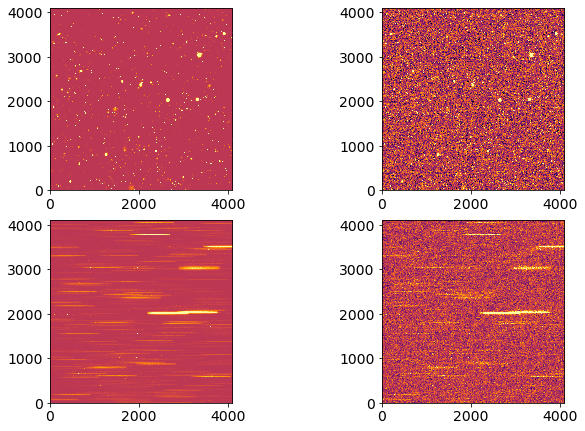

In [13]:
### Show them!

ncols = 2

all = [direct,new_direct,slitless,new_slitless]
print(all)

#N = len(all)
# not sure why this isn't working
#nrows = -(-N/ncols) # returns ceiling of division
#print(nrows)
nrows = 2

fig = plt.figure()

for i,a in enumerate(all):
    pf = pyfits.open(a)
    image = pf['SCI'].data
    print(np.mean(image),np.median(image),np.std(image))
    

    ax = fig.add_subplot(nrows,ncols,i+1)
    ax.imshow(image, interpolation='Nearest', 
              origin='lower', cmap='inferno',
              vmin=-0.1,vmax=0.1)
    #ax.scatter(primer['X_IMAGE'], primer['Y_IMAGE'], s=100,
    #               edgecolor='green', facecolor='none', alpha=0.7)

fig.tight_layout(pad=0.5)

## Show sources from primer catalogs

0.0037816963 0.0 0.051269267


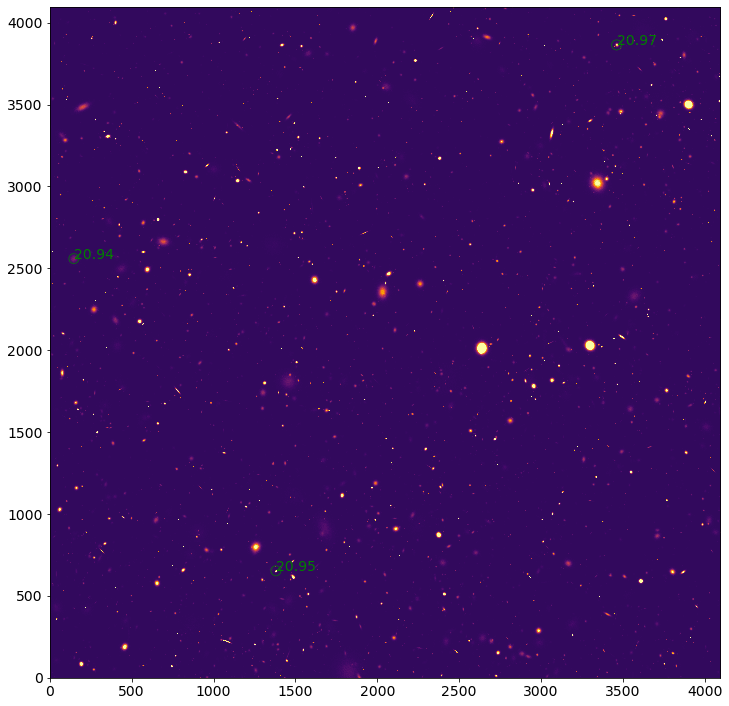

In [14]:
fig = plt.figure(figsize=(10,10))

pf = pyfits.open(direct)
image = pf['SCI'].data
print(np.mean(image),np.median(image),np.std(image))

#filt = primer['MAG_F1600W'] < 20
filt = (primer['MAG_F1600W'] > 20.9) & (primer['MAG_F1600W'] < 21)

    

ax = fig.add_subplot(111)
ax.imshow(image, interpolation='Nearest', 
           origin='lower', vmin=-0.1, vmax=0.5, cmap='inferno')
ax.scatter(primer['X_IMAGE'][filt], primer['Y_IMAGE'][filt], s=100,
            edgecolor='green', facecolor='none', alpha=0.7)
for i in range(len(primer[filt])):
    ax.text(primer[filt]['X_IMAGE'][i], primer[filt]['Y_IMAGE'][i],"%.2f" % (primer[filt]['MAG_F1600W'][i]),c="green")

fig.tight_layout(pad=0.5)

In [15]:
primer[filt]['NUMBER','RA','DEC','MAG_F1600W'].show_in_notebook()

In [ ]:
# Random
# 23961 10.0011107466  0.0149484929 18.49
# 8063  10.0412372492  0.0029643496 19.87
# 8990  10.005562076  -0.0566183098 20.79
# 606    9.9664018228 -0.0055298638 20.91 continuum
# 23115  9.958860925  -0.0350264133 20.98
# 2388  10.0098736134 -0.0298934341 21.95
# 21289  9.9912782697 -0.0334312864 22.92
# 12314 10.0110716308  0.05128653   23.97

## Find sources in the direct image
[top](#Table-of-Contents)

Just like the multi-mission, I am using SExtractor to find all of the sources in the direct images. This step is important not only for finding the sources but also for generating the segmentation map which will be used during the extraction of the spectra.

I may eventually adapt this to use SEP just like Grizli, but currently I understand SExtractor a little better.

The re-run the previous step, run this command.  In case you want to change the SExtractor parameters.

In [16]:
# remove segmentation FITS to redo "next" step
!rm *_seg.fits

rm: No match.


In [17]:
print(new_direct)

Roman_ATLAS_1deg_random2022_2022-01-27T06:04:27_RN0_v6_direct_final.fits


### Roman zero point calculation

[aXeSIM_Analysis.ipynb](aXeSIM_Analysis.ipynb)

/Users/gwalth/Dropbox/Research/aXeSIM/Roman/aXeSIM_Roman/analysis

In [18]:
## Make SExtractor catalog

#mag_zero = 25.91
mag_zero = 26.285 



#for direct in direct_files:
for direct in [new_direct]:

    prefix = direct.replace(".fits","")
    
    sex = "Roman.sex"
             
    cat = prefix + ".cat"   
    seg = prefix + "_seg.fits"
    bkg = prefix + "_bkg.fits"
    #aper = prefix + "_aper.fits"
    
    if not os.path.exists(seg):
        #os.system('wget http://www.stsci.edu/~brammer/grism/grizli_xdf_sextractor.tar.gz')
        #os.system('tar xzvf grizli_xdf_sextractor.tar.gz')
        
        #sex = prefix + ".sex"
        
        
        wht = direct + "[2]"
        direct_ext = direct + "[1]"
        
        checkimage_name = seg + "," + bkg
        #checkimage_name = seg + "," + bkg + "," + aper
        
        sex_str = 'sex ' + direct_ext + ' -c ' + sex + ' -WEIGHT_IMAGE ' + wht + \
                  ' -CHECKIMAGE_NAME ' + checkimage_name + ' -CATALOG_NAME ' + cat + \
                  ' -MAG_ZEROPOINT %.2f' % (mag_zero)
        os.system(sex_str)
        print(sex_str)

        #os.system('sex hlsp_xdf_hst_wfc3ir-60mas_hudf_f140w_v1_sci.fits ' + 
        #          '-c hlsp_xdf_hst_wfc3ir-60mas_hudf_f140w_v1.sex')
        

# awk '{ printf "circle(%f, %f, 0.00007) # text={%.3f}\n", $4, $5, $42 }' GRS_FOV1_roll0_dx0_dy0_SCA1_direct.cat > GRS_FOV1_roll0_dx0_dy0_SCA1_direct.reg
        

sex Roman_ATLAS_1deg_random2022_2022-01-27T06:04:27_RN0_v6_direct_final.fits[1] -c Roman.sex -WEIGHT_IMAGE Roman_ATLAS_1deg_random2022_2022-01-27T06:04:27_RN0_v6_direct_final.fits[2] -CHECKIMAGE_NAME Roman_ATLAS_1deg_random2022_2022-01-27T06:04:27_RN0_v6_direct_final_seg.fits,Roman_ATLAS_1deg_random2022_2022-01-27T06:04:27_RN0_v6_direct_final_bkg.fits -CATALOG_NAME Roman_ATLAS_1deg_random2022_2022-01-27T06:04:27_RN0_v6_direct_final.cat -MAG_ZEROPOINT 26.29


This a temporary. Around here is where I would loop over all of the detectors. 

In [19]:
print(cat)

Roman_ATLAS_1deg_random2022_2022-01-27T06:04:27_RN0_v6_direct_final.cat


## Check the pixel scale of the images

In [20]:
wcs_pixel_scale(direct)
wcs_pixel_scale(slitless)

Filename: Roman_ATLAS_1deg_random2022_2022-01-27T06:04:27_RN0_v6_direct_final.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       9   ()      
  1  SCI           1 ImageHDU        71   (4096, 4096)   float32   
  2  ERR           1 ImageHDU        71   (4096, 4096)   float32   
  3  DQ            1 ImageHDU        35   (4096, 4096)   int32   
cdelt1 = 0.1100 "/pixel
cdelt2 = -0.1100 "/pixel
crota1 = 180.0000 deg
crota2 = -0.0000 deg

Filename: Roman_ATLAS_1deg_random2022_2022-01-27T06:04:27_RN0_v6_slitless.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       8   ()      
  1  SCI           1 ImageHDU        71   (4096, 4096)   float32   
  2  ERR           1 ImageHDU        71   (4096, 4096)   float32   
  3  DQ            1 ImageHDU        35   (4096, 4096)   int32   
cdelt1 = 0.1100 "/pixel
cdelt2 = -0.1100 "/pixel
crota1 = 180.0000 deg
crota2 = -0.0000 deg



## Read SExtractor Photometry of Direct Images
[top](#Table-of-Contents)

In [21]:
print(cat)
phot = Table.read(cat, format='ascii.sextractor') # ref_cat in multimission
print(len(phot))

Roman_ATLAS_1deg_random2022_2022-01-27T06:04:27_RN0_v6_direct_final.cat
5505


In [22]:
filt = (phot['MAG_AUTO'] > 24) & (phot['MAG_AUTO'] < 25)
phot['NUMBER','X_WORLD','Y_WORLD','MAG_AUTO'][filt].show_in_notebook()



# random
ids = [4986, 3413, 2182, 387, 2349]
#print(phot["NUMBER"] == ids)

[phot[phot["NUMBER"] == id]['X_WORLD','Y_WORLD'].copy() for id in ids]
#print(phot['X_WORLD','Y_WORLD'][ids])


#id = phot['NUMBER'][np.argmin(dr)]
#obj_mag = phot['MAG_AUTO'][np.argmin(dr)]
#print('ID:%d, mag=%.2f' %(id, obj_mag))

[<Table length=1>
   X_WORLD        Y_WORLD    
     deg            deg      
   float64        float64    
 ------------ ---------------
 9.9465664653 -0.057815652369,
 <Table length=1>
   X_WORLD        Y_WORLD    
     deg            deg      
   float64        float64    
 ------------ ---------------
 9.9692488891 -0.016076914646,
 <Table length=1>
   X_WORLD        Y_WORLD    
     deg            deg      
   float64        float64    
 ------------ ---------------
 9.9911470171 0.0048137869576,
 <Table length=1>
   X_WORLD       Y_WORLD    
     deg           deg      
   float64       float64    
 ------------ --------------
 9.9498366545 0.045507257321,
 <Table length=1>
   X_WORLD       Y_WORLD    
     deg           deg      
   float64       float64    
 ------------ --------------
 9.9977927834 0.003551228292]

17.2756 99.0


(10.0, 32.0)

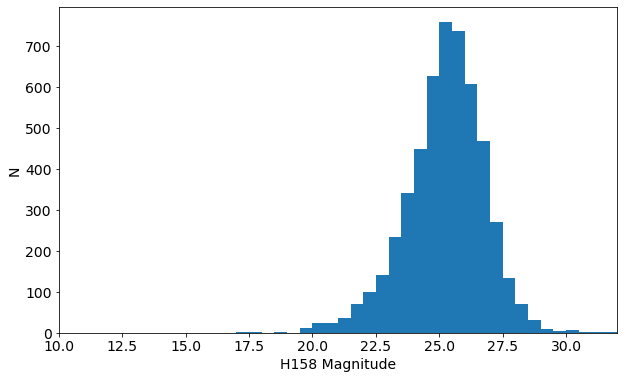

In [23]:
print(np.min(phot["MAG_AUTO"]),np.max(phot["MAG_AUTO"]))

fig = plt.figure()
p = fig.add_subplot(111)
p.hist(phot["MAG_AUTO"],range=(10,32),bins=44)
p.set_xlabel("H158 Magnitude")
p.set_ylabel("N")
p.set_xlim(10,32)

## (TESTING) Fake segmentation image - SKIP

In [ ]:
# create fake segmentation

yl, xl = 4088, 4088
#seg = np.zeros((yl, xl))

id = 6572
#r0, d0 = 53.2356312, -27.8250528 # emission line object?
x0, y0 = 1208.681132551118, 1574.86233818024
r = 45 # pixels

seg_img = create_circular_mask(yl,xl,[x0,y0],r)*id
print(seg_img)

seg = "seg.fits"
hdu = pyfits.PrimaryHDU(seg_img,header=head)
#hdu.verify('warn')''
hdu.writeto(seg,clobber=True)

In [ ]:
# display segmentation
ext = 0
pf = pyfits.open(seg)
seg_img = pf[ext].data


fig = plt.figure()
p1 = fig.add_subplot(111)
p1.imshow(seg_img)

In [ ]:
phot = phot[phot["NUMBER"] == id]
print(phot)

## Roman object simulation
[top](#Table-of-Contents)

In [24]:
### Roman GRS grism
# allow simulation of objects at the edges
#pad=0 # pixels
pad = 800 # I think this may be optimal given the spectra size (only seems to add 10-20 spectra)

# using the ZP Anihita gave me for the direct image

# sims              old  new 
#mag_limit = 18 #    34   11
#mag_limit = 20 #   273   49
#mag_limit = 22 #  1599  334 
#mag_limit = 24 #  5177 1830
#mag_limit = 26 # 10015 5704
#mag_limit = 28 #       7172
mag_limit = 30 

#h, wcs = grizli.fake_image.wfirst_header(ra=ra, dec=dec, pa_aper=pa_aper, naxis=(2048,2048))
#grizli.fake_image.make_fake_image(h, output='wfirst.fits', exptime=EXPTIME, nexp=NEXP)

Roman = grizli.model.GrismFLT(grism_file=new_slitless, verbose=True, pad=pad,  
                              ref_file=new_direct, ref_ext=1,
                              seg_file=seg, shrink_segimage=True)

Roman_cat = Roman.blot_catalog(phot, sextractor=True) 
Roman.catalog = Roman_cat

mask = Roman_cat['MAG_AUTO'] < mag_limit
print('N=%d' %(mask.sum()))
#Roman.compute_full_model(compute_beams=['A'], mask=mask, verbose=False)
Roman.compute_full_model(ids=Roman_cat['NUMBER'][mask], mags=Roman_cat['MAG_AUTO'][mask])
#Roman.compute_full_model(ids=Roman_cat['NUMBER'][mask], mags=Roman_cat['MAG_AUTO'][mask], verbose=True)

Roman_ATLAS_1deg_random2022_2022-01-27T06:04:27_RN0_v6_direct_final.fits
Roman_ATLAS_1deg_random2022_2022-01-27T06:04:27_RN0_v6_direct_final.fits[0]
Image cutout: x=slice(0, 4096, None), y=slice(0, 4096, None) [Out of range]
Roman_ATLAS_1deg_random2022_2022-01-27T06:04:27_RN0_v6_slitless_final.fits / blot reference Roman_ATLAS_1deg_random2022_2022-01-27T06:04:27_RN0_v6_direct_final.fits[0]
Using default C-based coordinate transformation...
Image cutout: x=slice(0, 4096, None), y=slice(0, 4096, None) [Out of range]
Roman_ATLAS_1deg_random2022_2022-01-27T06:04:27_RN0_v6_slitless_final.fits / Pad ref HDU with 1650 pixels
Roman_ATLAS_1deg_random2022_2022-01-27T06:04:27_RN0_v6_slitless_final.fits / blot segmentation Roman_ATLAS_1deg_random2022_2022-01-27T06:04:27_RN0_v6_direct_final_seg.fits[0]
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
N=5140


## (TESTING) Roman pad and magnitude test - SKIP

In [ ]:
### Roman GRS grism

# test set
#pads = [0]
#mag_limits = [18,20]

pads = [0,100,200,400,800]
mag_limits = [18,20,22,24,26]

info_list = []
cat_list = []
i = 0 # iter
N = len(pads) * len(mag_limits) # total iter

for pad in pads:
    for mag_limit in mag_limits:

        Roman = grizli.model.GrismFLT(grism_file=new_slitless, verbose=True, pad=pad,  
                                      ref_file=new_direct, ref_ext=1,
                                      seg_file=seg, shrink_segimage=True)

        Roman_cat = Roman.blot_catalog(phot, sextractor=True) 
        Roman.catalog = Roman_cat

        mask = Roman_cat['MAG_AUTO'] < mag_limit
        Ntot = mask.sum()
        
        Roman.compute_full_model(ids=Roman_cat['NUMBER'][mask], mags=Roman_cat['MAG_AUTO'][mask])
        
        ids_ext = []
        for id in Roman.object_dispersers:
            is_cgs, spectrum_1d, beam = Roman.object_dispersers[id]
            if len(beam) > 0: 
                ids_ext.append(id)
        
        ids_ext = np.array(ids_ext)
        Next = len(ids_ext)
        
        print()
        print('iter = %i of %i' % (i+1,N))
        print('%5s %9s %5s %5s %9s' % ("pad", "mag_limit", "Ntot", "Next", "Next/Ntot"))
        print('%5d %9d %5d %5d %9.3f' % (pad, mag_limit, Ntot, Next, Next/Ntot))
        print("\n")
        
        info_list.append([pad, mag_limit, Ntot, Next])
        
        extract_cat = Roman.catalog[ids_ext - 1] 
        cat_list.append(extract_cat)
        
        fig = plt.figure(figsize=[20,10])
        # Direct
        ax1 = fig.add_subplot(121)
        ax1.imshow(Roman.direct.data['REF']/Roman.direct.ref_photflam, interpolation='Nearest', 
                   origin='lower', vmin=-0.5, vmax=2.0, cmap='viridis')
        ax1.scatter(extract_cat['x_flt'], extract_cat['y_flt'], s=100,
                   edgecolor='white', facecolor='none', alpha=0.7)
        ax1.set_xticklabels([])
        ax1.set_title('pad=%d  mag_limit=%d  Ntot=%d  Next=%d' %(pad,mag_limit,Ntot,Next))

        # Grism
        ax2 = fig.add_subplot(122)
        ax2.imshow(Roman.model + Roman.grism.data['SCI'], interpolation='Nearest', 
                   origin='lower', vmin=-0.5, vmax=2.0, cmap='gray_r')
        ax2.scatter(extract_cat['x_flt'], extract_cat['y_flt'], s=100,
                   edgecolor='green', facecolor='none', alpha=0.7)
        ax2.set_title('%s - %s' %(Roman.grism.instrument, Roman.grism.filter))
        fig.tight_layout(pad=4.0)   
        
        i += 1
        
#print(info_list)


print("\n\n")
print("#"*12)
print("Test summary")
print("#"*12)
print('%5s %9s %5s %5s %9s' % ("pad", "mag_limit", "Ntot", "Next", "Next/Ntot"))
for info in info_list:
    pad, mag_limit, Ntot, Next = info
    print('%5d %9d %5d %5d %9.3f' % (pad, mag_limit, Ntot, Next, Next/Ntot))

print()
print(len(cat_list))
#print(cat_list)

## Check simulation
[top](#Table-of-Contents)

Possible problem with the aXeSIM conf file.  This function checks if the OrderDict exists within GrismFLT class.

In [25]:
all_cat,magcut_cat,extract_cat = check_sims(Roman, mag_limit)

All sources   = 5505
Magnitude cut = 5140
Simulated     = 5140



In [26]:
Roman.catalog[:20].show_in_notebook()

In [ ]:
#wcs = pywcs.WCS(head)

## Show direct images and slitless spectra
[top](#Table-of-Contents)

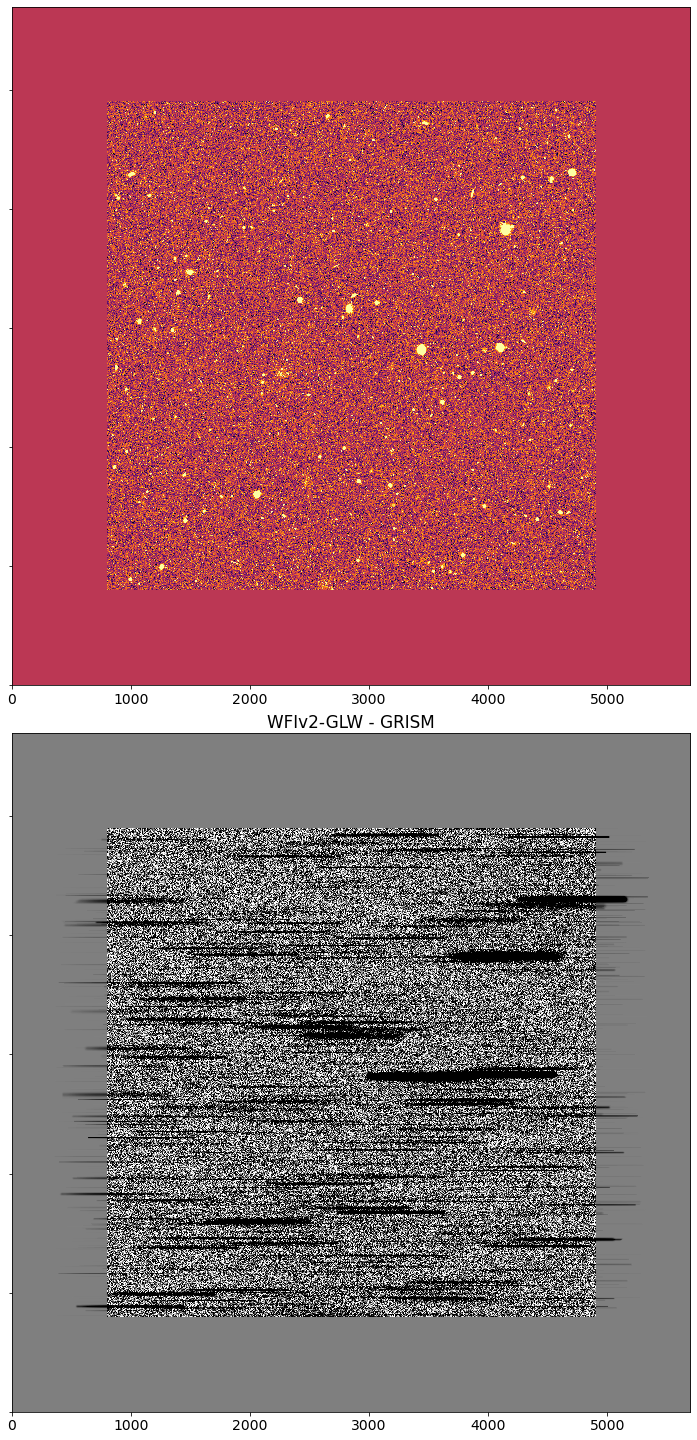

In [27]:
### Show them!

fig = plt.figure(figsize=[10,20])
# Direct
axt = fig.add_subplot(211)
axt.imshow(Roman.direct.data['REF']/Roman.direct.ref_photflam, interpolation='Nearest', 
           origin='lower', vmin=-0.1, vmax=0.1, cmap='inferno')
# Grism
axb = fig.add_subplot(212)
axb.imshow(Roman.model + Roman.grism.data['SCI'], interpolation='Nearest', 
           origin='lower', cmap='gray_r', vmin=-0.02, vmax=0.02)
axb.set_title('%s - %s' %(Roman.grism.instrument, Roman.grism.filter))
    

axt.set_yticklabels([])
axb.set_yticklabels([])

fig.tight_layout(pad=0.5)

## Show direct images and slitless spectra (with sources overplotted)

This is a check to see if there is a field dependence (or magnitude) to the failed simulations.

(-0.5, 5695.5)
(-0.5, 5695.5)
(-0.5, 5695.5)
(-0.5, 5695.5)


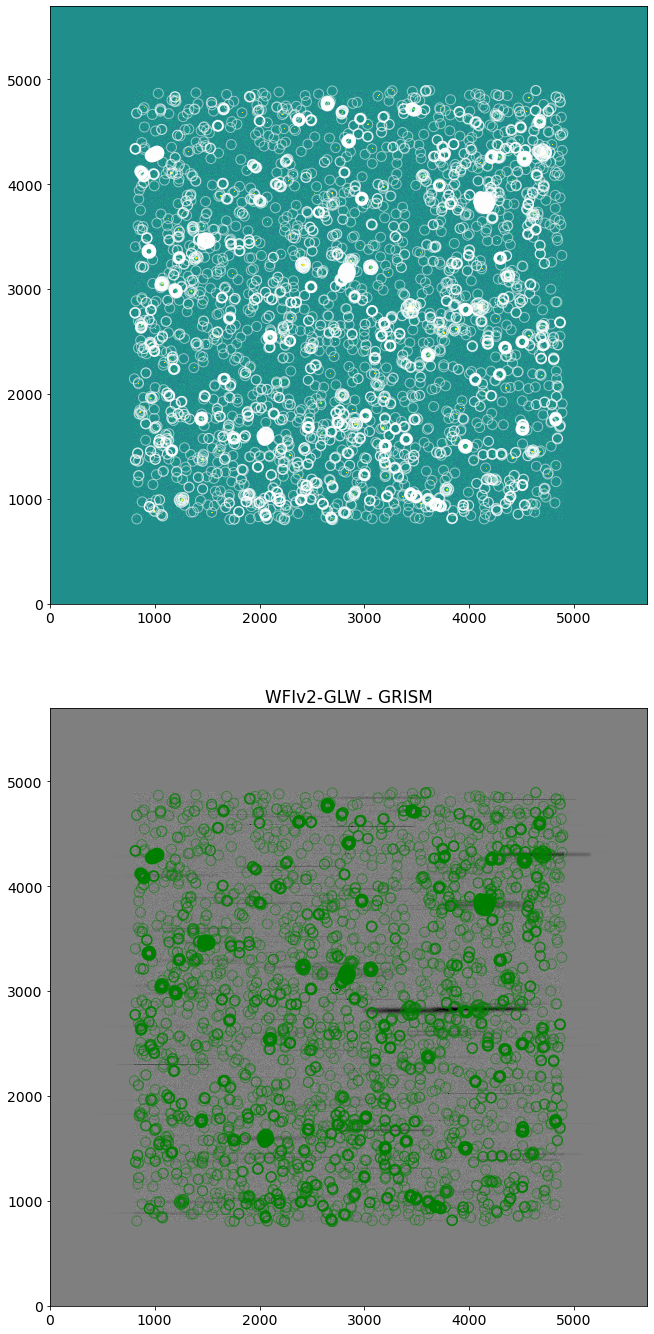

In [28]:
### Show them!
# Compare to the actual G141 exposure
fig = plt.figure(figsize=[10,20])

#extract_cat = Roman.catalog[0][0]

# Direct
#ax1 = fig.add_subplot(211, projection=wcs)
ax1 = fig.add_subplot(211)
ax1.imshow(Roman.direct.data['REF']/Roman.direct.ref_photflam, interpolation='Nearest', 
           origin='lower', vmin=-0.5, vmax=0.5, cmap='viridis')

ax1.scatter(extract_cat['x_flt'], extract_cat['y_flt'], s=100,
           edgecolor='white', facecolor='none', alpha=0.5)

#ax1.set_xticklabels([])
print(ax1.get_xlim())
print(ax1.get_ylim())
    
# Grism
#ax2 = fig.add_subplot(212, projection=wcs)
ax2 = fig.add_subplot(212)
ax2.imshow(Roman.model + Roman.grism.data['SCI'], interpolation='Nearest', 
           origin='lower', vmin=-0.5, vmax=0.5, cmap='gray_r')

ax2.scatter(extract_cat['x_flt'], extract_cat['y_flt'], s=100,
           edgecolor='green', facecolor='none', alpha=0.5)


ax2.set_title('%s - %s' %(Roman.grism.instrument, Roman.grism.filter))
print(ax2.get_xlim())
print(ax2.get_ylim())

fig.tight_layout(pad=4.0)

In [29]:
print(phot.colnames)
print(phot["X_WORLD","Y_WORLD"])
print(phot["MAG_AUTO"])

['NUMBER', 'X_IMAGE', 'Y_IMAGE', 'X_WORLD', 'Y_WORLD', 'A_IMAGE', 'B_IMAGE', 'THETA_IMAGE', 'A_WORLD', 'B_WORLD', 'THETA_WORLD', 'FLUX_APER', 'FLUX_APER_1', 'FLUX_APER_2', 'FLUX_APER_3', 'FLUX_APER_4', 'FLUX_APER_5', 'FLUX_APER_6', 'FLUX_APER_7', 'FLUX_APER_8', 'FLUX_APER_9', 'FLUX_APER_10', 'FLUX_APER_11', 'FLUX_APER_12', 'FLUX_APER_13', 'FLUXERR_APER', 'FLUXERR_APER_1', 'FLUXERR_APER_2', 'FLUXERR_APER_3', 'FLUXERR_APER_4', 'FLUXERR_APER_5', 'FLUXERR_APER_6', 'FLUXERR_APER_7', 'FLUXERR_APER_8', 'FLUXERR_APER_9', 'FLUXERR_APER_10', 'FLUXERR_APER_11', 'FLUXERR_APER_12', 'FLUXERR_APER_13', 'FLUX_AUTO', 'FLUXERR_AUTO', 'MAG_AUTO', 'MAGERR_AUTO', 'MAG_BEST', 'MAGERR_BEST', 'KRON_RADIUS', 'PETRO_RADIUS', 'BACKGROUND', 'THRESHOLD', 'ERRA_IMAGE', 'ERRB_IMAGE', 'ERRTHETA_IMAGE', 'ERRA_WORLD', 'ERRB_WORLD', 'ERRTHETA_WORLD', 'XWIN_IMAGE', 'YWIN_IMAGE', 'AWIN_IMAGE', 'BWIN_IMAGE', 'THETAWIN_IMAGE', 'ERRAWIN_IMAGE', 'ERRBWIN_IMAGE', 'ERRTHETAWIN_IMAGE', 'MU_THRESHOLD', 'FLAGS', 'FWHM_IMAGE', 'FLU

## (TESTING) Filter catalog based on position on the detector and magnitude - SKIP

In [ ]:
# OLD - DO NOT RUN!

cat = Roman.catalog
cat["NUMBER","MAG_AUTO","id","ra","dec","x_flt","y_flt"]
#cat.colnames

x_filt = (cat['x_flt'] > 2400) & (cat['x_flt'] < 2600)
y_filt = (cat['y_flt'] > 3900) & (cat['y_flt'] < 4100)
mag_filt = (cat['MAG_AUTO'] < 24)

filt = x_filt & y_filt & mag_filt

print(cat[filt]['MAG_AUTO','id',"ra","dec","x_flt","y_flt"])

## (TESTING) Reload Core Grizli Python Functions - SKIP

Only use if you are editing the Python code while running the Jupyter notebook.

In [ ]:
from importlib import reload
reload(grizli.model)

## Loop over all objects and fit their redshifts
[top](#Table-of-Contents)

In [29]:
os.chdir(os.path.join(HOME_PATH, root, 'Extraction'))

In [32]:
# Smaller Test 
Nl = [id for id in phot['NUMBER']][:2]

# Test 
#Nl = [id for id in phot['NUMBER']][:10]

# All sources
#Nl = [id for id in phot['NUMBER']]

# Problem, might need try/except in fitting
print(Nl)

[1, 2]


In [31]:
fwhm = 325 # km/s
t0 = utils.load_templates(fwhm=fwhm, line_complexes=True, fsps_templates=True) # redshift fits, fixed line ratios
t1 = utils.load_templates(fwhm=fwhm, line_complexes=False, fsps_templates=True) # final fits

# This breaks if there is a magnitude cut!!!
#for id in phot['NUMBER']:
for id in Nl:

    print(id)
    
    #beams = OrderedDict()

    is_cgs, spectrum_1d, b = Roman.object_dispersers[id]
    cutout = grizli.model.BeamCutout(Roman, b['A'], min_sens=0,) # min_mask=0) 

    cutout.beam.compute_model()  
    cutout.contam = cutout.beam.cutout_from_full_image(Roman.model)
    if id in Roman.object_dispersers:
        cutout.contam -= cutout.beam.model

    #beams[Roman.grism.instrument] = cutout

    
    #############################
    # old lines of code (working)
    #############################   
    #cutout.write_fits() # still learning
    #beam = 'beam__%05d.grism.A.fits' % (id)
    #new_beam = beam.replace(".fits","_GLW.fits")

    #ext = 0
    #hdu = pyfits.open(beam)
    #hdu[ext].header['EXPTIME'] = hdu['SCI'].header['EXPTIME']
    #hdu.writeto(new_beam,clobber=True)

    #mb = multifit.MultiBeam([new_beam], fcontam=0.2, group_name=root, psf=False, min_sens=0.05)
    #mb.write_master_fits()
    
    
    ###########################
    # new lines of code to test
    ###########################
    hdu = cutout.write_fits(get_hdu=True)
    ext = 0
    hdu[ext].header['EXPTIME'] = hdu['SCI'].header['EXPTIME']

    beam = 'beam_%05d.grism.A.fits' % (id)
    hdu.writeto(beam,clobber=True)

    mb = multifit.MultiBeam([beam], fcontam=0.2, group_name=root, psf=False, min_sens=0.05)
    mb.write_master_fits()
    ###########################
    
    

    fitting.run_all(id, t0, t1, fit_only_beams=True, fwhm=fwhm, zr=[0.05, 3.0], 
                    dz=[0.004, 0.0002], fitter=['nnls', 'bounded'], group_name=root)

1


KeyError: 1

In [ ]:
# Test 
Nl = [id for id in phot['NUMBER']][:2]

# All sources
#Nl = [id for id in phot['NUMBER']]

# Problem, might need try/except in fitting
print(Nl)

In [ ]:
# Loop test

fwhm = 325 # km/s
t0 = utils.load_templates(fwhm=fwhm, line_complexes=True, fsps_templates=True) # redshift fits, fixed line ratios
t1 = utils.load_templates(fwhm=fwhm, line_complexes=False, fsps_templates=True) # final fits

# This breaks if there is a magnitude cut!!!
#for id in phot['NUMBER']:
for id in Nl:

    print(id)
    
    #beams = OrderedDict()

    is_cgs, spectrum_1d, b = Roman.object_dispersers[id]
    cutout = grizli.model.BeamCutout(Roman, b['A'], min_sens=0,) # min_mask=0) 

    cutout.beam.compute_model()  
    cutout.contam = cutout.beam.cutout_from_full_image(Roman.model)
    if id in Roman.object_dispersers:
        cutout.contam -= cutout.beam.model
        
    #print(cutout.grism)
    #print(dir(cutout))
    #print(cutout.__dict__)
    print(cutout.grism.filter)
    
    continue

    #beams[Roman.grism.instrument] = cutout

    cutout.write_fits() # still learning

    beam = 'beam__%05d.grism.A.fits' % (id)
    new_beam = beam.replace(".fits","_GLW.fits")

    ext = 0
    hdu = pyfits.open(beam)
    hdu[ext].header['EXPTIME'] = hdu['SCI'].header['EXPTIME']
    hdu.writeto(new_beam,clobber=True)

    mb = multifit.MultiBeam([new_beam], fcontam=0.2, group_name=root, psf=False, min_sens=0.05)
    mb.write_master_fits()
    
    ###########################
    # new lines of code to test
    ###########################
    #hdu = cutout.write_fits(get_hdu=True)
    #ext = 0
    #hdu[ext].header['EXPTIME'] = hdu['SCI'].header['EXPTIME']

    #beam = 'beam_%05d.grism.A.fits' % (id)
    #hdu.writeto(beam,clobber=True)

    #mb = multifit.MultiBeam([beam], fcontam=0.2, group_name=root, psf=False, min_sens=0.05)
    #mb.write_master_fits()
    ###########################
    

    fitting.run_all(id, t0, t1, fit_only_beams=True, fwhm=fwhm, zr=[0.05, 3.0], 
                    dz=[0.004, 0.0002], fitter=['nnls', 'bounded'], group_name=root)

In [ ]:
print(type(Roman))

## Inspect Redshift Fitting Results
[top](#Table-of-Contents)

In [ ]:
os.chdir(os.path.join(HOME_PATH, root, 'Extraction'))

# Find ids of all the extracted objects
ids = []
files = glob.glob('*full.fits')
for file in files:
    #print(file)
    ids.append(int(file.replace(".full.fits","").split("_")[-1]))

#print(files)

ids.sort()
print(ids)
print("N =",len(ids))

In [ ]:
# ids of extracted objects sorted on magnitude
#new_ids = [pid for pid in phot["NUMBER"] if pid in ids]
#new_mag = [m for pid,m in phot["NUMBER","MAG_AUTO"] if pid in ids]
new_cat = [[pid,m,x,y] for pid,m,x,y in phot["NUMBER","MAG_AUTO",'X_WORLD','Y_WORLD'] if pid in ids]
#print(new_ids)
#print(new_mag)
print(new_cat)
print(phot.colnames)

In [ ]:
zfits = ['CHIMIN','DOF','Z02','Z16','Z50','Z84','Z97','ZWIDTH1',
         'ZWIDTH2','Z_RISK','MIN_RISK','Z_MAP','GAM_LOSS']

zfits_dict = {'NUMBER':[], 'REDSHIFT':[], 'MAG_AUTO':[], "X_WORLD":[], "Y_WORLD":[]}
for zf in zfits:
    zfits_dict[zf] = []

#for i,(id,mag) in enumerate(zip(new_ids,new_mag)):   
for i,(id,mag,x,y) in enumerate(new_cat):   
    #id = int(file.replace(".full.fits","").split("_")[-1])
    zfits_dict["NUMBER"].append(id)
    zfits_dict["MAG_AUTO"].append(mag)
    zfits_dict["X_WORLD"].append(x)
    zfits_dict["Y_WORLD"].append(y)
    #print("\n")
    #print(i)
    full_hdu = pyfits.open('{0}_{1:05d}.full.fits'.format(root, id))
    #print(full_hdu.info())
    #head = full_hdu[0].header
    #zfit_stack = Table(full_hdu['ZFIT_STACK'].data)

    head = full_hdu[0].header
    zfits_dict['REDSHIFT'].append(head['REDSHIFT'])
    
    
    head = full_hdu['ZFIT_STACK'].header
    
    #print(head[zfits])
    for zf in zfits:
        #head[zf],head.comments[zf]
        #print(head[zf],)
        zfits_dict[zf].append(head[zf])
    #print("\n")
    
#print(zfits_dict)

zfits_table = Table(zfits_dict)
print(zfits_table)
#print(zfits_table["CHIMIN"]/zfits_table["DOF"])
print(zfits_table["ZWIDTH1","ZWIDTH2"])

In [ ]:
vec1 = zfits_table["X_WORLD","Y_WORLD"]
zfits_table["VEC"] = vec1
print(vec1)

In [ ]:
fig = plt.figure()
p1 = fig.add_subplot(111)
#p1.scatter(zfits_table["Z_RISK"], zfits_table["MIN_RISK"])
p1.scatter(zfits_table["ZWIDTH1"], zfits_table["ZWIDTH2"])

p1.plot([0.0001,10.0],[0.05,0.05],"--",c="k")
p1.plot([0.05,0.05],[0.0001,10.0],"--",c="k")

p1.set_xlabel("zwidth1 [16th and 84th p(z) percentile]")
p1.set_ylabel("zwidth2 [2.5th and 97.5th p(z) percentile]")
p1.set_xscale("log")
p1.set_yscale("log")
p1.set_xlim(0.0001,10.0)
p1.set_ylim(0.0001,10.0)

fig = plt.figure(figsize=(12,4))
p1 = fig.add_subplot(121)
p1.scatter(zfits_table["REDSHIFT"], zfits_table["ZWIDTH1"])
#p1.plot([0,3.5],[0.1,0.1],"--",c="k")
p1.plot([0,3.5],[0.05,0.05],"--",c="k")
p1.set_xlabel("Redshift")
p1.set_ylabel("zwidth1 [16th and 84th p(z) percentile]")
p1.set_yscale("log")
p1.set_ylim(0.0001,10.0)

p2 = fig.add_subplot(122)
p2.scatter(zfits_table["REDSHIFT"], zfits_table["ZWIDTH2"])
#p2.plot([0,3.5],[0.1,0.1],"--",c="k")
p2.plot([0,3.5],[0.05,0.05],"--",c="k")
p2.set_xlabel("Redshift")
p2.set_ylabel("zwidth2 [2.5th and 97.5th p(z) percentile]")
p2.set_yscale("log")
p2.set_ylim(0.0001,10.0)

In [ ]:
#zcut = 0.05
zcut = 0.01
#zcut = 0.005

filt1 = zfits_table["ZWIDTH1"] < zcut
zfits_filt1 = zfits_table[filt1]

fig = plt.figure(figsize=(12,10))

p1 = fig.add_subplot(221)
p1.scatter(zfits_table["REDSHIFT"], zfits_table["ZWIDTH1"], s=2, c="k")
p1.scatter(zfits_filt1["REDSHIFT"], zfits_filt1["ZWIDTH1"])
#p1.plot([0,3.5],[0.1,0.1],"--",c="k")
p1.plot([0,3.5],[zcut,zcut],"--",c="k")
p1.set_xlabel("Redshift")
p1.set_ylabel("z$_{width1}$ [16th and 84th p(z) percentile]")
p1.set_yscale("log")
p1.set_ylim(0.0001,10.0)

p2 = fig.add_subplot(222)
p2.scatter(zfits_table["REDSHIFT"], zfits_table["MAG_AUTO"], s=2, c="k")
p2.scatter(zfits_filt1["REDSHIFT"], zfits_filt1["MAG_AUTO"])
#p2.plot([0,3.5],[0.1,0.1],"--",c="k")
#p2.plot([0,3.5],[0.05,0.05],"--",c="k")
p2.set_xlabel("Redshift")
p2.set_ylabel("Mag")
#p2.set_yscale("log")
#p2.set_ylim(0.0001,10.0)


filt2 = zfits_table["ZWIDTH2"] < zcut
zfits_filt2 = zfits_table[filt2]

p3 = fig.add_subplot(223)
p3.scatter(zfits_table["REDSHIFT"], zfits_table["ZWIDTH2"], s=2, c="k")
p3.scatter(zfits_filt2["REDSHIFT"], zfits_filt2["ZWIDTH2"])
#p3.plot([0,3.5],[0.1,0.1],"--",c="k")
p3.plot([0,3.5],[zcut,zcut],"--",c="k")
p3.set_xlabel("Redshift")
p3.set_ylabel("z$_{width2}$ [2.5th and 97.5th p(z) percentile]")
p3.set_yscale("log")
p3.set_ylim(0.0001,10.0)

p4 = fig.add_subplot(224)
p4.scatter(zfits_table["REDSHIFT"], zfits_table["MAG_AUTO"], s=2, c="k")
p4.scatter(zfits_filt2["REDSHIFT"], zfits_filt2["MAG_AUTO"])
#p4.plot([0,3.5],[0.1,0.1],"--",c="k")
#p4.plot([0,3.5],[0.05,0.05],"--",c="k")
p4.set_xlabel("Redshift")
p4.set_ylabel("Mag")
#p4.set_yscale("log")
#p4.set_ylim(0.0001,10.0)

print(zfits_filt1['NUMBER'])
print(zfits_filt2['NUMBER'])


Important note:

In the in initial catalog generation, I need RA and DEC or some other identifier to push along and tag the sources properly for their magnitudes and redshifts.  If I can map the sources correctly then I should be able to adjust any magnitude differences.

In [ ]:
os.chdir(os.path.join(HOME_PATH, root, 'Prep'))

#primer_cat = "ATLAS_1deg_subsample_cat_random_primer.cat"
primer_cat = "ATLAS_1deg_subsample_primer_small.lis"
print(primer_cat)
primer = Table.read(primer_cat, format='ascii.sextractor')
primer[:10].show_in_notebook()
print(len(primer))
print(primer.colnames)

In [ ]:
vec2 = primer["NUMBER","RA","DEC"]
primer["VEC"] = vec2
print(vec2)

primer[:10].show_in_notebook()

In [ ]:


# https://docs.astropy.org/en/stable/api/astropy.table.join_distance.html#astropy.table.join_distance


#all_table = join(zfits_table, primer, keys='NUMBER')


#new_index = []
r_all = []
new_number = []
for i,t1 in enumerate(zfits_table):
    rmin = 1E9
    #print(i)
    x1,y1 = t1["X_WORLD","Y_WORLD"]
    #print(x1,y1)
    for j,t2 in enumerate(primer):
        num,x2,y2 = t2["NUMBER","RA","DEC"]     
        r = np.sqrt((x1-x2)**2*np.cos(y2/180*np.pi)**2+(y1-y2)**2)*3600.
        
        
        #print("%.2f %.2f %.2f %.2f %.2f" % (r,x1,y1,x2,y2))
        if r < rmin: 
            #save_index = j
            save_r = r
            save_num = num
            rmin = r
    
    #print(i,save_index,save_r)
    #print()
    
    #new_index.append(save_index)
    r_all.append(save_r)
    new_number.append(save_num)
    
print(new_index)

zfits_table["NUMBER"] = new_number
zfits_table["DR"] = r_all

In [ ]:
from astropy.table import Table, join #, join_distance

all_table = join(zfits_table, primer, join_type='inner', keys="NUMBER")

#all_table = join(zfits_table, primer, join_type='outer', join_funcs={'vec': join_distance(0.1)})

In [ ]:
all_table[:10].show_in_notebook()

In [ ]:
fig = plt.figure(figsize=(12,6))

p1 = fig.add_subplot(121)
p1.scatter(all_table["REDSHIFT_1"], all_table["REDSHIFT_2"], s=2, c="k")

p2 = fig.add_subplot(122)
p2.scatter(all_table["MAG_AUTO"], all_table["MAG"], s=2, c="k")

In [ ]:
os.chdir(os.path.join(HOME_PATH, root, 'Extraction'))

id = 25

f_1d = '{0}_{1:05d}.1D.fits'.format(root, id)
#print(f_1d)
oned_hdu = pyfits.open(f_1d)
print(oned_hdu[1].header)
print(oned_hdu.info())
grism = Table(oned_hdu['GRISM'].data)
print(grism.colnames)

signal = np.sum(grism['flux'])
noise = np.sqrt(np.sum(grism['err']**2))
print(signal)
print(noise)

print(signal/noise)

#full_hdu = pyfits.open('{0}_{1:05d}.full.fits'.format(root, id))
#print(full_hdu.info())
print(grism['line'])
plt.plot(grism['flat'])

In [ ]:
S_N = []
for id in phot['NUMBER']:
    f_1d = '{0}_{1:05d}.1D.fits'.format(root, id)
    oned_hdu = pyfits.open(f_1d)
    grism = Table(oned_hdu['GRISM'].data)

    signal = np.sum(grism['flux'])
    noise = np.sqrt(np.sum(grism['err']**2))
    S_N.append(signal/noise)

phot['S_N'] = np.array(S_N)

In [ ]:
print(phot['S_N'])

In [ ]:
plt.scatter(phot['S_N'],phot['MAG_AUTO'])

In [ ]:
plt.hist(phot['S_N'],bins=10,range=[0,20])

In [ ]:
filt = phot['S_N'] < 6.5
print(len(phot[filt]))

# Appendix

## Extract a single 2D spectrum 
Science, model and contamination based on RA and Dec

[top](#Table-of-Contents)

ID:4178, mag=22.62, dr=0.16"
WFIv2-GLW 1887.497365065002 1742.1608487018004
(False, None, OrderedDict([('A', <grizli.model.GrismDisperser object at 0x7fcd32a11438>)]))
['MW_EBV', 'MW_F99', 'NX', 'PAM_value', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'add_to_full_image', 'add_ytrace_offset', 'beam', 'compute_model', 'compute_model_psf', 'conf', 'contained_in_full_array', 'cutout_from_full_image', 'direct', 'dx', 'dxfull', 'dxpix', 'flat_index', 'fwcpos', 'get_PAM_value', 'get_psf_sensitivity', 'grow', 'id', 'idx', 'init_extended_epsf', 'init_galactic_extinction', 'init_optimal_profile', 'is_cgs', 'lam', 'lam_beam', 'lam_sort', 'model', 'modelf', 'optimal_extract', 'origin', 'pad', 'process_

'beam__04178.grism.A.fits'

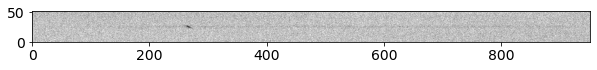

In [31]:
## Find the object ID near coordinates (r0,d0), 
## SExtractor IDs might not be constant across platforms

#small 
#r0,d0 = 9.9667504,  0.0240604 # 19.94
#r0,d0 = 9.9542018, -0.0588458 # 21.10
#r0,d0 = 9.9490562, -0.0373860 # 22.13
#r0,d0 = 9.9465051, -0.0405907 # 23.01
#r0,d0 = 9.9589560,  0.0124919 # 23.98

#random                                MAG    ATLAS NUMBER
#r0,d0 = 10.0011107466,  0.0149484929 # 18.49  23961 continuum
#r0,d0 = 10.0412372492,  0.0029643496 # 19.87  8063 mostly continuum
#r0,d0 = 10.005562076,  -0.0566183098 # 20.79  8990 continuum
#r0,d0 =  9.9664018228, -0.0055298638 # 20.91  606 continuum
#r0,d0 = 10.0265397928, -0.0393050944 # 20.97  2118 emission, probably Ha (good!!!), modspec=1752
#r0,d0 =  9.958860925,  -0.0350264133 # 20.98 23115 
#r0,d0 = 10.0098736134, -0.0298934341 # 21.95  2388 emission
#r0,d0 =  9.9912782697, -0.0334312864 # 22.92  21289 emission or contaminate?
#r0,d0 = 10.0110716308,  0.05128653   # 23.97  12314 ?

# 2118 old
# 1571 new
r0,d0 = 10.0265397928, -0.0393050944 # 20.97  Ha (good!!!)


dr = np.sqrt((phot['X_WORLD']-r0)**2*np.cos(d0/180*np.pi)**2 + 
             (phot['Y_WORLD']-d0)**2)*3600.
id = phot['NUMBER'][np.argmin(dr)]
obj_mag = phot['MAG_AUTO'][np.argmin(dr)]
print('ID:%d, mag=%.2f, dr=%.2f"' %(id, obj_mag, np.min(dr)))

beams = OrderedDict()


ix = Roman.catalog['id'] == id
x0, y0 = Roman.catalog['x_flt'][ix][0], Roman.catalog['y_flt'][ix][0]
print(Roman.direct.instrument, x0, y0)
#print(Roman.wcs.pscale)
#dim = 18*0.135/sim.flt_wcs.pscale 
#beam = grizli.model.BeamCutout(id=id, x=x0, y=y0, 
#                               cutout_dimensions=np.cast[int]((dim, dim)), 
#                               conf=sim.conf, GrismFLT=sim)

print(Roman.object_dispersers[id])

is_cgs, spectrum_1d, b = Roman.object_dispersers[id]
#print(b)

cutout = grizli.model.BeamCutout(Roman, b['A'], min_sens=0,) # min_mask=0) 

cutout.beam.compute_model()  
cutout.contam = cutout.beam.cutout_from_full_image(Roman.model)
if id in Roman.object_dispersers:
    cutout.contam -= cutout.beam.model

print(dir(cutout.beam))
#print(cutout.contam)
#print(cutout.beam.model)
#print(dir(cutout.beam))
print(cutout.beam.seg)
print(cutout.beam.seg.shape)

fig = plt.figure()
p1 = fig.add_subplot(111)
p1.imshow(cutout.grism.data['SCI']*1, origin='lower',cmap='gray_r')
#p1.imshow(cutout.grism.data['ERR']*1)#,vmin=-0.1,vmax=0.1, origin='lower',cmap='gray_r')
    
beams[Roman.grism.instrument] = cutout

cutout.write_fits() # still learning about the output

## aXeSIM predictions based on conf file
[top](#Table-of-Contents)

In [ ]:
os.chdir(os.path.join(HOME_PATH, root, 'Prep'))

In [ ]:
from grizli import grismconf

In [ ]:
# This one gives the error
import os
os.chdir("/Users/gwalth/data/Roman/grizli/grizli/CONF")
conf = grismconf.load_grism_config("./Roman.det1.07242020.conf")

# This one works!
#conf = grismconf.load_grism_config("../../../grizli/CONF/Roman.det1.07242020.conf")
#conf = grismconf.load_grism_config("../../../grizli/CONF/Roman_bad/Roman.det1.07242020.conf")

dx = conf.dxlam["A"]
print(dx)
dy,lam = conf.get_beam_trace(x=x0,y=y0,dx=dx)
print(dy)
print(lam)

In [ ]:
conf.show_beams()

In [ ]:
print(os.getcwd())

In [ ]:
for i in range(1,19): 
    conf = grismconf.load_grism_config("../../../grizli/CONF/Roman.det%i.07242020.conf" % (i)) 
    #conf = grismconf.load_grism_config("../../../grizli/CONF/Roman_bad/Roman.det%i.07242020.conf" % (i))
    dx = conf.dxlam["A"]
    print(dx)
    dy,lam = conf.get_beam_trace(x=x0,y=y0,dx=dx)
    print(dy)
    print(lam)
    conf.show_beams()

## Show 2D beam
[top](#Table-of-Contents)

[[ 0.03734256 -0.00447751 -0.00069738 ... -0.0112637   0.01275776
   0.01908004]
 [-0.04716174 -0.02997619 -0.01964864 ...  0.04111255  0.02820396
  -0.01403279]
 [-0.00888891 -0.00432445 -0.0020517  ...  0.02570675  0.00329995
   0.00626166]
 ...
 [-0.013974   -0.02778172  0.00373513 ...  0.00385551  0.06983951
   0.03976845]
 [ 0.01880336 -0.01463492  0.00744049 ...  0.03026555  0.04358795
  -0.01363079]
 [-0.02312729  0.00179003  0.03000356 ...  0.0628572   0.02761991
  -0.00362806]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0.         0.         0.         ... 0.00015037 0.00015086 0.00015134]
 [0.         0.         0.         ... 0.00024412 0.0002459  0.00024768]
 [0.         0.         0.         ... 0.00049723 0.0005002  0.00050317]
 ...
 [0.00851882 0.00851961 0.00852018 ... 0.00460054 0.00460404 0.00460764]
 [0.01047232 0.01047433 0.01047592 ... 0.00553767 0.005

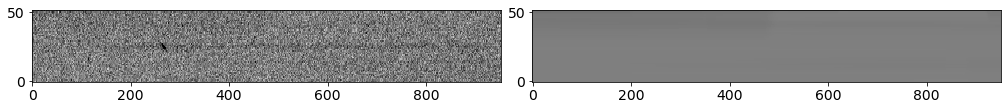

In [32]:
## Spectrum with lines & noise
#spectrum_file = os.path.join(os.path.dirname(grizli.__file__), 'data/erb2010.dat')
#spectrum_file = '../../../grizli/templates/erb2010.dat'
#erb = np.loadtxt(spectrum_file, unpack=True)
#z = 2.0 # test redshift

## normalize spectrum to unity to use normalization defined in the direct image
#import pysynphot as S
#spec = S.ArraySpectrum(erb[0], erb[1], fluxunits='flam')
#spec = spec.redshift(z).renorm(1., 'flam', S.ObsBandpass('wfc3,ir,f140w'))
#spec.convert('flam') # bug in pysynphot, now units being converted automatically above? (11/10/16)

fig = plt.figure(figsize=(14,4))
for i, key in enumerate(beams.keys()):
    #     beams[key].compute_model(beams[key].thumb, id=beams[key].id, 
    #                              xspec=spec.wave, yspec=spec.flux)
    #print(key)
    #beams[key].beam.compute_model(spectrum_1d=[spec.wave, spec.flux]) 
    #beams[key].beam.compute_model()
    
    gdata = beams[key].grism.data['SCI']*1
    gmodel = beams[key].model
    gcontam = beams[key].contam
    
    print(gdata)
    print(gmodel)
    print(gcontam)
    
    print(np.min(gdata),np.max(gdata))
    print(np.min(gmodel),np.max(gmodel))
    print(np.min(gcontam),np.max(gcontam))
    
    print(gdata.shape)
    print(gmodel.shape)
    print(gcontam.shape)
    
    axl = fig.add_subplot(321+i*2)
    #axl.imshow(beams[key].model + beams[key].grism.data['SCI']*1, interpolation='Nearest', 
    #       origin='lower', vmin=-0.006, vmax=0.16, cmap='gray_r', aspect='auto')
    
    axl.imshow(beams[key].grism.data['SCI']*1, interpolation='Nearest', 
           origin='lower', vmin=-0.1,vmax=0.1, cmap='gray_r', aspect='auto')
    
    
    axr = fig.add_subplot(321+i*2+1)
    #axr.imshow(beams[key].contam + beams[key].grism.data['SCI'] + beams[key].model, 
    #           interpolation='Nearest', 
    #           origin='lower', vmin=-1, vmax=2, cmap='gray_r', aspect='auto')

    axr.imshow(beams[key].contam , 
               interpolation='Nearest', 
               origin='lower', vmin=-0.1,vmax=0.1, cmap='gray_r', aspect='auto')
    
    #axl.set_title('%s - %s' %(key, beams[key].grism.filter))
    #for ax in [axl, axr]:
    #    beams[key].beam.twod_axis_labels(wscale=1.e4, mpl_axis=ax)
    #    beams[key].beam.twod_xlim(1.3,1.75, wscale=1.e4, mpl_axis=ax)
    #    if i < 2:
    #        ax.set_xticklabels([])
    #    else:
    #        ax.set_xlabel(r'$\lambda$')

fig.tight_layout(pad=0.5)

In [33]:
def ab2flux(mab,eff_wav):
    c = 2.9979E10 # cm/s
    Ang = 1E-8    # cm
    Jy = 1E-23    # erg/s/cm^2/Hz
    
    # mab = -2.5*np.log10(fnu) - 48.6 
    fnu = 10**(-0.4*(mab + 48.6))          # erg/s/cm^2/Hz
    flambda = fnu*(c/(eff_wav*Ang)**2)*Ang # erg/s/cm^2/Ang
   
    #print("%.2f AB" % (mab))
    #print("%.2e erg/s/cm^2/Hz" % (fnu))
    #print("%.2e Jy" % (fnu/Jy))
    #print("%.4f uJy" % (fnu/(1e-6*Jy)))
    #print("%.1f nJy" % (fnu/(1e-9*Jy)))
    #print()
    #print("%.2e erg/s/cm^2/Ang" % (flambda))
    #print()
    
    return flambda

In [34]:
# determine flux in Ang for the source in the direct image

mab = phot[phot['NUMBER']==id]['MAG_AUTO'][0]

f_scale = ab2flux(mab,15800.)

## Simple SN calculations based on the spcontetc
[top](#Table-of-Contents)

In [35]:
# Per pix S/N=1
mag_per_pix_w0 = 21.9       # 1.00 um
mag_per_pix_w1 = 21.9       # 1.93 um
mag_per_pix_deepest = 22.7  # 1.34 um

In [36]:
ab2flux(mag_per_pix_w0,10000.)
ab2flux(mag_per_pix_deepest,13400.)

5.042054612716202e-19

/Users/gwalth/data/Roman/grizli/my_roman_sims/Prep
 col1   col2   col3    col4      col5    col6    col7 
------ ------ ----- ---------- ------- ------- -------
   1.0 0.8657 117.1  5139800.0 21.1989 20.5715 21.3113
1.0581 0.8747 115.9  6604600.0 21.4656 20.8438  21.578
1.1162 0.8837 114.7  7990600.0 21.6669 21.0506 21.7792
1.1744 0.8928 113.6  9035700.0 21.7948 21.1841 21.9072
1.2325 0.9019 112.4  9767600.0 21.8738 21.2686 21.9862
1.2906 0.9111 111.3 10058000.0 21.9001 21.3004 22.0125
1.3487 0.9202 110.2 10102000.0 21.8995 21.3052 22.0118
1.4069 0.9295 109.1  9958700.0 21.8785 21.2897 21.9909
 1.465 0.9387 108.0  9582200.0 21.8313 21.2478 21.9437
1.5231  0.948 106.9  9120700.0 21.7724 21.1942 21.8847
1.5812 0.9574 105.9  8608500.0 21.7043 21.1315 21.8166
1.6394 0.9668 104.9  8131600.0 21.6371 21.0696 21.7495
1.6975 0.9762 103.9  7587000.0 21.5566 20.9943 21.6689
1.7556 0.9857 102.9  7023200.0 21.4675 20.9105 21.5799
1.8137 0.9952 101.9  6384100.0 21.3587 20.8069 21.4711
1.8719 1.0047 

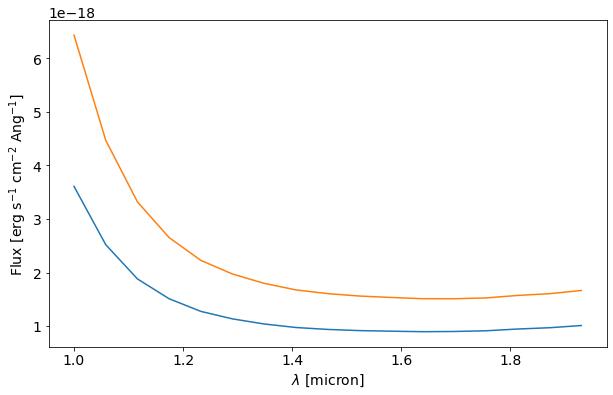

In [37]:
print(os.getcwd())
spcontetc_1n = Table.read("../etc/spcontetc_1n_0.2.dat",format="ascii")
spcontetc_8n = Table.read("../etc/spcontetc_8n_0.2.dat",format="ascii")
#spcontetc_1n = Table.read("../etc/spcontetc_1n_0.5.dat",format="ascii")
#spcontetc_8n = Table.read("../etc/spcontetc_8n_0.5.dat",format="ascii")
print(spcontetc_1n)

#|  um  | arcsec |      |exp per Jy|per pix |per resl|1e4 km/s|
fig = plt.figure()
p = fig.add_subplot(111)
#for n in range(5,8):
for n in range(5,7):
    #p.plot(spcontetc_1n['col1'],spcontetc_1n['col%i' % (n)]) # AB
    #p.plot(spcontetc_8n['col1'],spcontetc_8n['col%i' % (n)]) # AB
    
    f1 = ab2flux(spcontetc_1n['col%i' % (n)],spcontetc_1n['col1']*1e4)
    f8 = ab2flux(spcontetc_8n['col%i' % (n)],spcontetc_8n['col1']*1e4)
    
    p.plot(spcontetc_1n['col1'],f1)  
    #p.plot(spcontetc_8n['col1'],f8) 

    

#p.set_ylim(0e-18,2e-18)
p.set_xlabel(r'$\lambda$ [micron]')
p.set_ylabel(r'Flux [erg s$^{-1}$ cm$^{-2}$ Ang$^{-1}$]')
#p.set_ylabel(r'Mag [AB]')

#p.invert_yaxis()
    
plt.show()

Roughly estimated from spcontetc (>1.4 micron):

<span style="color:red">5 sigma limit = 1.75e-18 erg/s/cm^2/Ang</span>

<span style="color:red">1 sigma limit = 1.00e-18 erg/s/cm^2/Ang</span>


## Simple SN calculations based on the pzcaletc
[top](#Table-of-Contents)

/Users/gwalth/data/Roman/grizli/my_roman_sims/Prep
 col1      col2        col3    ...    col10       col11       col12   
------ ----------- ----------- ... ----------- ----------- -----------
   1.0 2.71013e-19 3.55783e-19 ... 1.52512e-18 1.70082e-18 1.87693e-18
1.0332 2.29307e-19 3.00404e-19 ... 1.28054e-18 1.42783e-18 1.57547e-18
1.0664 1.95075e-19  2.5503e-19 ...  1.0811e-18 1.20524e-18  1.3297e-18
1.0996  1.7056e-19 2.22525e-19 ... 9.38094e-19 1.04565e-18 1.15347e-18
1.1329 1.53269e-19 1.99562e-19 ... 8.36668e-19  9.3244e-19 1.02845e-18
1.1661 1.40447e-19 1.82501e-19 ...  7.6096e-19 8.47925e-19 9.35111e-19
1.1993 1.30661e-19 1.69451e-19 ... 7.02705e-19 7.82881e-19 8.63265e-19
1.2325 1.23327e-19 1.59629e-19 ... 6.58392e-19 7.33389e-19 8.08584e-19
1.2657 1.18471e-19 1.53051e-19 ... 6.27861e-19 6.99264e-19 7.70856e-19
1.2989 1.15543e-19 1.48988e-19 ...  6.0792e-19 6.76941e-19 7.46149e-19
   ...         ...         ... ...         ...         ...         ...
1.5979 1.20602e-19 1.53148

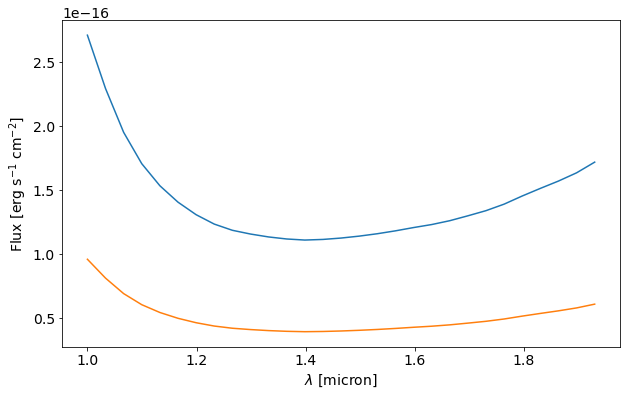

In [38]:
print(os.getcwd())
pzcaletc_1n = Table.read("../etc/pzcaletc_1n.dat",format="ascii")
pzcaletc_8n = Table.read("../etc/pzcaletc_8n.dat",format="ascii")
print(pzcaletc_1n)

fig = plt.figure()
p = fig.add_subplot(111)
#for n in range(2,13):
for n in range(2,3):
    #p.plot(pzcaletc_1n['col1'],pzcaletc_1n['col%i' % (n)]) # W/m^2
    p.plot(pzcaletc_1n['col1'],pzcaletc_1n['col%i' % (n)]*1000.) # erg/s/cm^2
    p.plot(pzcaletc_8n['col1'],pzcaletc_8n['col%i' % (n)]*1000.) # erg/s/cm^2

    
#p.legend(fontsize=14)
#p.set_xlim(w1-0.05, w2+0.05)
#p.set_ylim(-1e-21,3e-20)
p.set_xlabel(r'$\lambda$ [micron]')
p.set_ylabel(r'Flux [erg s$^{-1}$ cm$^{-2}$]')
    
plt.show()

## Simple SN calculations based on the apttables2021
[top](#Table-of-Contents)

/Users/gwalth/data/Roman/grizli/my_roman_sims/Prep


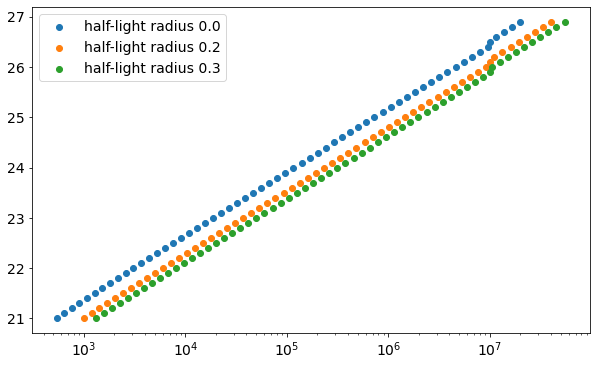

In [39]:
print(os.getcwd())
apt_rad0_0_zod1_2 = Table.read("../apttables2021/grism/spec_half-light-rad0.0_zod1.2.dat",format="ascii",
                               names=('AB','1.05','1.20','1.40','1.60','1.80','2.00'))
apt_rad0_2_zod1_2 = Table.read("../apttables2021/grism/spec_half-light-rad0.2_zod1.2.dat",format="ascii",
                               names=('AB','1.05','1.20','1.40','1.60','1.80','2.00'))
apt_rad0_3_zod1_2 = Table.read("../apttables2021/grism/spec_half-light-rad0.3_zod1.2.dat",format="ascii",
                               names=('AB','1.05','1.20','1.40','1.60','1.80','2.00'))
#print(apt_rad0_0_zod1_2)
#print(apt_rad0_2_zod1_2)
#print(apt_rad0_3_zod1_2)

fig = plt.figure()
p = fig.add_subplot(111)

wlist = ['1.05','1.20','1.40','1.60','1.80','2.00']

#for w in wlist:
#    p.plot(apt_rad0_0_zod1_2[w],apt_rad0_0_zod1_2['AB'],label=w) 

p.scatter(apt_rad0_0_zod1_2['1.20'],apt_rad0_0_zod1_2['AB'],label='half-light radius 0.0')
p.scatter(apt_rad0_2_zod1_2['1.20'],apt_rad0_0_zod1_2['AB'],label='half-light radius 0.2')
p.scatter(apt_rad0_3_zod1_2['1.20'],apt_rad0_0_zod1_2['AB'],label='half-light radius 0.3')
    
p.legend(fontsize=14)
p.set_xscale("log")

#p.set_xlim(0,2000)
#p.set_ylim(20,22)
    
plt.show()

1.05
[16.9065836   1.27383247]
20.063862085214456

1.20
[17.18572913  1.27166514]
20.3376357493578

1.40
[17.07030217  1.27266754]
20.224693289505403

1.60
[16.71749973  1.27527391]
19.878350918078727

1.80
[16.27650476  1.27830027]
19.44485697276647

2.00
[16.03502399  1.27968244]
19.20680200026952



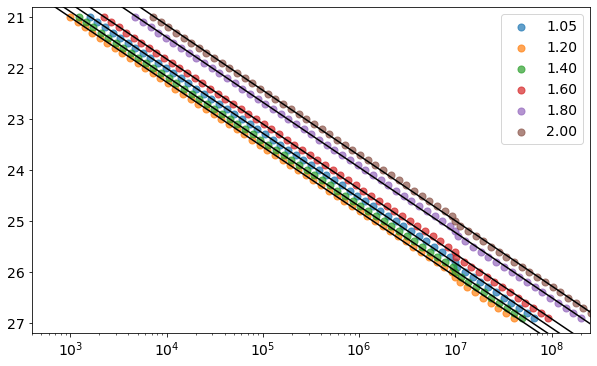

In [40]:
##############
# My crude ETC
# based on 
# https://roman.gsfc.nasa.gov/science/apttables2021/table-grism.html
##############

# notes:
# might need a fit cutoff to t = 1e7 

from scipy.optimize import leastsq

t = 301.

param = [1,0]
err = 1.0

# y = ax + b
line_fn = lambda p,x: p[1]*x+p[0]

err_fn = lambda p: (line_fn(p,x) - y)/err

wlist = ['1.05','1.20','1.40','1.60','1.80','2.00'] # microns

mag_ab_5sig = []

fig = plt.figure()
p = fig.add_subplot(111)

#x = np.log10(apt_rad0_0_zod1_2['1.20'])
y = apt_rad0_2_zod1_2['AB']
for w in wlist:
    print(w)
    x = np.log10(apt_rad0_2_zod1_2[w])

    sol = leastsq(err_fn,param,full_output=1)
    print(sol[0])

    mag_ab = line_fn(sol[0],np.log10(t))
    print(mag_ab)
    mag_ab_5sig.append(mag_ab)
    print()

    logt = np.arange(2.0,8.6,0.1)
    mag = line_fn(sol[0],logt)
    

    p.plot(10**logt,mag,c="k")
    p.scatter(10**x,y,label=w,s=50,alpha=0.7)
    
p.legend(fontsize=14)
p.set_xscale("log")

p.set_xlim(400,2.5e8)
p.set_ylim(20.8,27.2)

p.invert_yaxis()
plt.show()

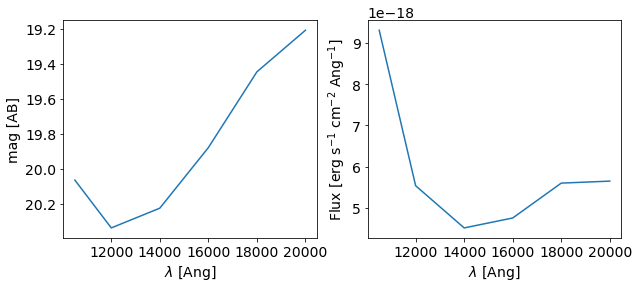

In [41]:
fig = plt.figure(figsize=(10,4))
p1 = fig.add_subplot(121)

warr = 1e4*np.array([float(w0) for w0 in wlist]) # Angstroms


mag_ab_5sig = np.array(mag_ab_5sig)

p1.plot(warr,mag_ab_5sig)
p1.set_xlabel(r'$\lambda$ [Ang]')
p1.set_ylabel(r'mag [AB]')
p1.invert_yaxis()


#p.set_xlim(0,2000)
#p.set_ylim(20,22)
p2 = fig.add_subplot(122)

#flux_5sig = [ab2flux(mag_ab_5sig[i],w0) for i,w0 in enumerate(warr)]
flux_5sig = ab2flux(mag_ab_5sig,warr) 
p2.plot(warr,flux_5sig)

p2.set_xlabel(r'$\lambda$ [Ang]')
p2.set_ylabel(r'Flux [erg s$^{-1}$ cm$^{-2}$ Ang$^{-1}$]')
    
plt.show()

Comparison between spcontetc and apttables2021

/Users/gwalth/data/Roman/grizli/my_roman_sims/Prep
 col1   col2   col3    col4      col5    col6    col7 
------ ------ ----- ---------- ------- ------- -------
   1.0 0.8657 117.1  5139800.0 21.1989 20.5715 21.3113
1.0581 0.8747 115.9  6604600.0 21.4656 20.8438  21.578
1.1162 0.8837 114.7  7990600.0 21.6669 21.0506 21.7792
1.1744 0.8928 113.6  9035700.0 21.7948 21.1841 21.9072
1.2325 0.9019 112.4  9767600.0 21.8738 21.2686 21.9862
1.2906 0.9111 111.3 10058000.0 21.9001 21.3004 22.0125
1.3487 0.9202 110.2 10102000.0 21.8995 21.3052 22.0118
1.4069 0.9295 109.1  9958700.0 21.8785 21.2897 21.9909
 1.465 0.9387 108.0  9582200.0 21.8313 21.2478 21.9437
1.5231  0.948 106.9  9120700.0 21.7724 21.1942 21.8847
1.5812 0.9574 105.9  8608500.0 21.7043 21.1315 21.8166
1.6394 0.9668 104.9  8131600.0 21.6371 21.0696 21.7495
1.6975 0.9762 103.9  7587000.0 21.5566 20.9943 21.6689
1.7556 0.9857 102.9  7023200.0 21.4675 20.9105 21.5799
1.8137 0.9952 101.9  6384100.0 21.3587 20.8069 21.4711
1.8719 1.0047 

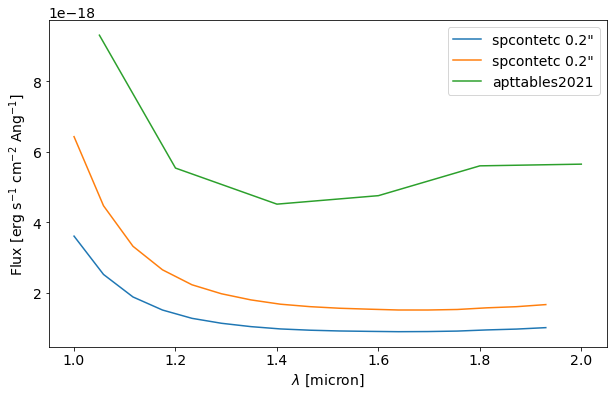

In [42]:
print(os.getcwd())
spcontetc_1n = Table.read("../etc/spcontetc_1n_0.2.dat",format="ascii")
spcontetc_8n = Table.read("../etc/spcontetc_8n_0.2.dat",format="ascii")
#spcontetc_1n = Table.read("../etc/spcontetc_1n_0.5.dat",format="ascii")
#spcontetc_8n = Table.read("../etc/spcontetc_8n_0.5.dat",format="ascii")
print(spcontetc_1n)

fig = plt.figure()
p = fig.add_subplot(111)
#for n in range(5,8):
for n in range(5,7):
    #p.plot(spcontetc_1n['col1'],spcontetc_1n['col%i' % (n)]) # AB
    #p.plot(spcontetc_8n['col1'],spcontetc_8n['col%i' % (n)]) # AB
    
    f1 = ab2flux(spcontetc_1n['col%i' % (n)],spcontetc_1n['col1']*1e4)
    f8 = ab2flux(spcontetc_8n['col%i' % (n)],spcontetc_8n['col1']*1e4)
    
    p.plot(spcontetc_1n['col1'],f1,label='spcontetc 0.2"')  
    #p.plot(spcontetc_8n['col1'],f8) 


p.plot(warr/1e4,flux_5sig,label="apttables2021")

#p.set_ylim(0e-18,2e-18)
p.set_xlabel(r'$\lambda$ [micron]')
p.set_ylabel(r'Flux [erg s$^{-1}$ cm$^{-2}$ Ang$^{-1}$]')
#p.set_ylabel(r'Mag [AB]')

#p.invert_yaxis()
p.legend()
    
plt.show()

/Users/gwalth/data/Roman/grizli/my_roman_sims/Prep
[-89.73592326  77.61208193]
[-83.6428632   70.94594587]
[-78.20641729  64.87689421]
[-73.46963447  59.36232707]
[-69.28273412  54.34397954]
[-65.72085523  49.79099686]
[-62.64147186  45.65285153]
[-60.05724564  41.89840377]
[-57.95166067  38.49699191]
[-56.24834874  35.41336941]
[-54.93318715  32.62060131]
[-54.01679502  30.09920097]
[-53.34708151  27.81057906]
[-53.00846767  25.74680748]
[-52.91265734  23.88085463]
[-52.97789776  22.18950959]
[-53.16897768  20.65338192]
[-53.48210357  19.26091405]
[-53.73410632  17.98106236]
[-53.9253553   16.80236472]
[-53.98302069  15.70915605]
[-53.81022041  14.6822372 ]
[-53.36483199  13.70985933]
[-52.56235365  12.77654852]
[-51.44862146  11.88220921]
[-49.9025894   11.00754667]
[-47.98663786  10.15628615]
[-45.71173246   9.32432037]
[-43.14690747   8.51575659]
[-40.24825771   7.72247578]
[-37.22931989   6.96405922]
[-34.07105941   6.2363996 ]
[-30.91143484   5.5511502 ]
[-27.79044612   4.9083109

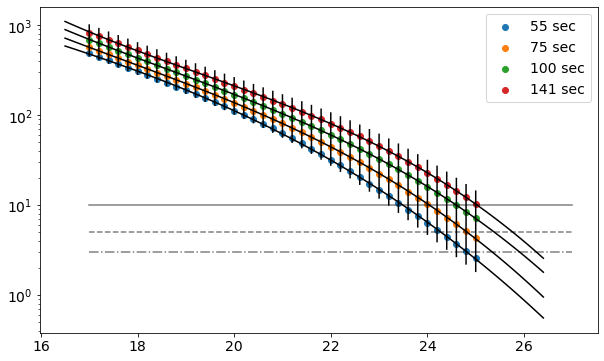

In [43]:
def poly_n(p, x):
    p = np.array(p)
    y = np.zeros((x.shape[0],))
    for n in np.arange(p.shape[0]):
        y += p[n]*x**n
    return y

def solve_for_y(poly_coeffs, y):
    pc = poly_coeffs.copy()
    print(pc)
    pc[0] -= y
    print(pc)
    return np.roots(pc)


print(os.getcwd())
apt_SN_55sec_zod1_2 = Table.read("../apttables2021/imaging/ap_phot_2pix_0.22rad_SN_55sec_zod1.2x.dat",format="ascii",
                               names=('AB','F062','F087','F106','F129','F158','F184','F146','F213'))
apt_SN_75sec_zod1_2 = Table.read("../apttables2021/imaging/ap_phot_2pix_0.22rad_SN_75sec_zod1.2x.dat",format="ascii",
                               names=('AB','F062','F087','F106','F129','F158','F184','F146','F213'))
apt_SN_100sec_zod1_2 = Table.read("../apttables2021/imaging/ap_phot_2pix_0.22rad_SN_100sec_zod1.2x.dat",format="ascii",
                               names=('AB','F062','F087','F106','F129','F158','F184','F146','F213'))


img_table = Table()
img_table['AB'] = apt_SN_55sec_zod1_2['AB']
img_table['55'] = apt_SN_55sec_zod1_2['F158']
img_table['75'] = apt_SN_75sec_zod1_2['F158']
img_table['100'] = apt_SN_100sec_zod1_2['F158']


#print(img_table)

t = 141

# SNR ~ t^(0.5)
# time
x = np.sqrt(np.array([55.,75.,100.]))
param = [1, 0]
err = 1.0

line_fn = lambda p,x: p[1]*x+p[0]

err_fn = lambda p: (line_fn(p,x) - y)/err

fig = plt.figure()
p = fig.add_subplot(111)

SN = [] # at t

###################
# fit for SNR and t
###################
for i,y in enumerate(img_table['55','75','100']):

    # SNR
    y = np.array(list(y))
    
    sol = leastsq(err_fn,param,full_output=1)
    print(sol[0])
    
    t0 = np.arange(50,200,0.1)
    snr = line_fn(sol[0],np.sqrt(t0))
    
    mag = np.ones(snr.shape)*img_table['AB'][i]

    p.plot(mag,snr,c="k")
    
    SN.append(line_fn(sol[0],np.sqrt(t)))

img_table['141'] = SN



param = [1,1,1,1]
# mag
x = img_table['AB']
#print(x)
err = np.ones(x.shape)
#err[:5] = 0.01
#err[-5:] = 0.01

err_fn2 = lambda p: (poly_n(p,x) - y)/err
#####################
# fit for SNR and mag
#####################

dict = {}

for i,t0 in enumerate(['55','75','100','141']):
    
    # SNR
    y = 2.5*np.log10(img_table[t0])
    
    sol = leastsq(err_fn2,param,full_output=1)
    print(sol[0])
    
    mag = np.arange(16.5,26.5,0.1)
    snr = 10**(0.4*poly_n(sol[0],mag))
    
    p.plot(mag,snr,c="k")
    print(len(sol[0]))
    
    dict['sol%s' % t0] = sol[0]

#################
# solving for s/n
#################
print(dict)
sol0 = dict['sol141']
print(solve_for_y(sol0,2.5*np.log10(10.0)))


p.scatter(img_table['AB'],img_table['55'],label='55 sec')
p.scatter(img_table['AB'],img_table['75'],label='75 sec')
p.scatter(img_table['AB'],img_table['100'],label='100 sec')
p.scatter(img_table['AB'],SN,label='141 sec')


p.plot([17,27],[10,10],"-",c="k",alpha=0.5)
p.plot([17,27],[5,5],"--",c="k",alpha=0.5)
p.plot([17,27],[3,3],"-.",c="k",alpha=0.5)

p.legend(fontsize=14)
p.set_yscale("log")

#p.set_xlim(0,2000)
#p.set_ylim(20,22)
#p.invert_yaxis()
    
plt.show()

/Users/gwalth/data/Roman/grizli/my_roman_sims/Prep


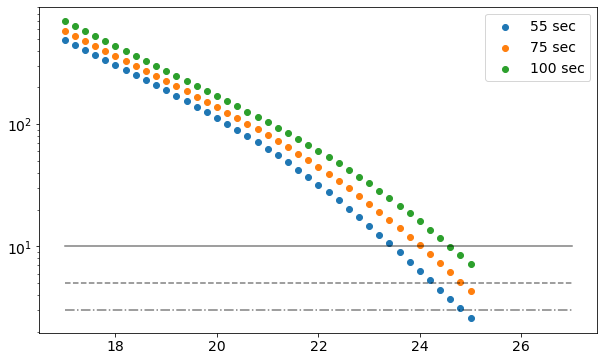

In [44]:
print(os.getcwd())
apt_SN_55sec_zod1_2 = Table.read("../apttables2021/imaging/ap_phot_2pix_0.22rad_SN_55sec_zod1.2x.dat",format="ascii",
                               names=('AB','F062','F087','F106','F129','F158','F184','F146','F213'))
apt_SN_75sec_zod1_2 = Table.read("../apttables2021/imaging/ap_phot_2pix_0.22rad_SN_75sec_zod1.2x.dat",format="ascii",
                               names=('AB','F062','F087','F106','F129','F158','F184','F146','F213'))
apt_SN_100sec_zod1_2 = Table.read("../apttables2021/imaging/ap_phot_2pix_0.22rad_SN_100sec_zod1.2x.dat",format="ascii",
                               names=('AB','F062','F087','F106','F129','F158','F184','F146','F213'))
#print(apt_rad0_0_zod1_2)
#print(apt_rad0_2_zod1_2)
#print(apt_rad0_3_zod1_2)

fig = plt.figure()
p = fig.add_subplot(111)

flist = ['F062','F087','F106','F129','F158','F184','F146','F213']

#for f in flist:
#    p.scatter(apt_SN_55sec_zod1_2['AB'],apt_SN_55sec_zod1_2[f],label=f) 
    #p.scatter(apt_SN_75sec_zod1_2['AB'],apt_SN_75sec_zod1_2[f],label=f)
    #p.scatter(apt_SN_100sec_zod1_2['AB'],apt_SN_100sec_zod1_2[f],label=f) 

p.scatter(apt_SN_55sec_zod1_2['AB'],apt_SN_55sec_zod1_2['F158'],label='55 sec')
p.scatter(apt_SN_75sec_zod1_2['AB'],apt_SN_75sec_zod1_2['F158'],label='75 sec')
p.scatter(apt_SN_100sec_zod1_2['AB'],apt_SN_100sec_zod1_2['F158'],label='100 sec')


p.plot([17,27],[10,10],"-",c="k",alpha=0.5)
p.plot([17,27],[5,5],"--",c="k",alpha=0.5)
p.plot([17,27],[3,3],"-.",c="k",alpha=0.5)

p.legend(fontsize=14)
p.set_yscale("log")

#p.set_xlim(0,2000)
#p.set_ylim(20,22)
#p.invert_yaxis()
    
plt.show()

## Roman Sensitivity Function

[top](#Table-of-Contents)

In [45]:
print(os.getcwd())
print(HOME_PATH)
#os.chdir(os.path.join(HOME_PATH, root, 'Extraction'))

/Users/gwalth/data/Roman/grizli/my_roman_sims/Prep
/Users/gwalth/data/Roman/grizli


### Gabe's Roman sensitivity function

In [46]:
sens_file = HOME_PATH + '/grizli/CONF/Roman.G150.v1.6.sens.fits' # Gabe's
sens_cat1 = Table.read(sens_file)
print(sens_cat1.colnames)

['WAVELENGTH', 'SENSITIVITY', 'ERROR']


### Anahita's Roman sensitivity function

In [47]:
sens_file = HOME_PATH + '/grizli/CONF/sens_0720_2020.fits'
sens_cat2 = Table.read(sens_file)
print(sens_cat2.colnames)

['WAVELENGTH', 'SENSITIVITY', 'ERROR']


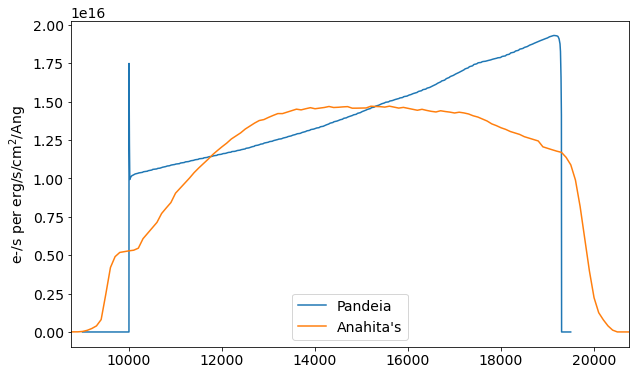

In [48]:
fig = plt.figure()

p1 = fig.add_subplot(111)
#p1.errorbar(sens_cat1['WAVELENGTH'],sens_cat1['SENSITIVITY'],yerr=sens_cat1['ERROR'])
#p1.errorbar(sens_cat2['WAVELENGTH'],sens_cat2['SENSITIVITY'],yerr=sens_cat2['ERROR'])
p1.plot(sens_cat1['WAVELENGTH'],sens_cat1['SENSITIVITY'],label="Pandeia")
p1.plot(sens_cat2['WAVELENGTH'],sens_cat2['SENSITIVITY'],label="Anahita's")
#p1.plot(pzcaletc_1n['col1']*1e4,1./(pzcaletc_1n['col%i' % (n)]*1000.)) # erg/s/cm^2
#p1.plot(pzcaletc_8n['col1']*1e4,1./(pzcaletc_8n['col%i' % (n)]*1000.)) # erg/s/cm^2
p1.set_xlim(8750,20750)
p1.set_ylabel("e-/s per erg/s/cm$^2$/Ang") # according to axe_manual
p1.legend()

## 1D Spectral Extraction
[top](#Table-of-Contents)

WFIv2-GLW

sum = 9.54e+01
mean = 1.04e-01
median = 1.02e-01
std = 6.60e-02
min = -8.96e-02
max = 5.81e-01
S/N = 0.01

sum = 3.89e-19
mean = 4.24e-22
median = 4.17e-22
std = 2.70e-22
min = -3.66e-22
max = 2.37e-21
S/N = 0.01

P(1) = -1.18e-22
P(25) = 2.62e-22
P(50) = 4.17e-22
P(75) = 5.78e-22
P(95) = 8.04e-22
P(99) = 1.12e-21
P(99.9) = 2.30e-21

Chunk  W0  W1  Sum  Mean  Median  STD  Min  Max  S/N
  1  0.948  0.961  0.00e+00  nan  nan  nan  nan  nan     nan
  2  0.963  0.977  1.21e-21  1.10e-22  6.01e-23  1.45e-22  -4.56e-23  4.52e-22     0.1
  3  0.978  0.991  2.82e-21  2.17e-22  2.51e-22  1.80e-22  -1.63e-22  5.86e-22     0.1
  4  0.992  1.006  2.33e-21  1.67e-22  1.77e-22  1.63e-22  -1.79e-22  5.31e-22     0.1
  5  1.007  1.021  1.88e-21  1.34e-22  5.43e-23  2.48e-22  -2.63e-22  6.60e-22     0.1
  6  1.022  1.035  2.98e-21  2.30e-22  2.32e-22  1.40e-22  4.73e-24  5.09e-22     0.1
  7  1.036  1.051  2.53e-21  1.81e-22  2.27e-22  1.59e-22  -1.02e-22  4.36e-22     0.1
  8  1.052  1.065 

Text(0, 0.5, 'S/N')

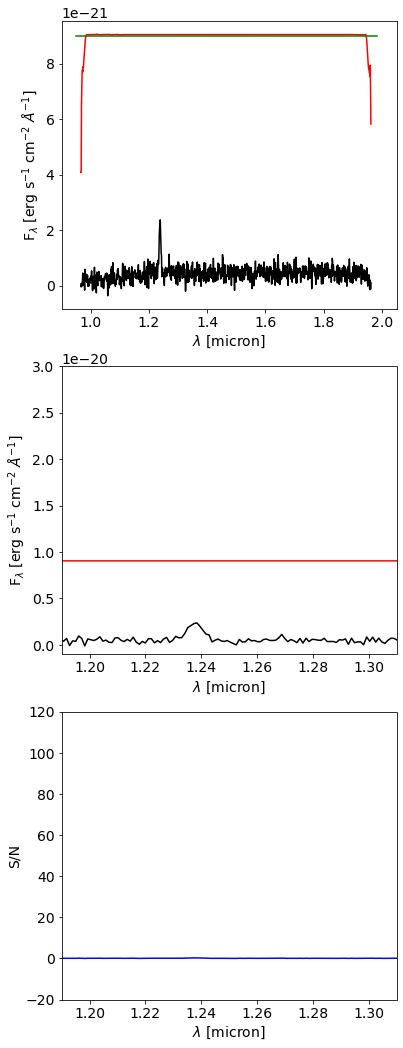

In [49]:
from scipy import integrate

### Plot 1D spectra
fig = plt.figure(figsize=(6,18))
p1 = fig.add_subplot(311)
p2 = fig.add_subplot(312)
p3 = fig.add_subplot(313)
for i, key in enumerate(beams.keys()):
    print(key)
    print()
    w, f, e = beams[key].beam.optimal_extract(beams[key].model+beams[key].grism.data['SCI'], bin=0)
    #w, f, e = beams[key].beam.optimal_extract(beams[key].grism.data['SCI'], 
    #                                          ivar=1./(beams[key].grism.data['ERR'])**2,bin=0)
    
    # normalize to the magnitude in the direct image
    print("sum = %.2e" % (np.nansum(f)))
    print("mean = %.2e" % (np.nanmean(f)))
    print("median = %.2e" % (np.nanmedian(f)))
    print("std = %.2e" % (np.nanstd(f)))
    print("min = %.2e" % (np.nanmin(f)))
    print("max = %.2e" % (np.nanmax(f)))
    
    
    print("S/N = %.2f" % (np.nanmax(f)/np.sqrt(np.nansum(e**2))))
    print()
    #

    
    # Method 1
    scale = f_scale/np.nansum(f)
    f = f * scale
    e = e * scale
    # Method 2
    #f = (f/np.nanmedian(f)) * f_scale
    # Method 3
    #skysub = f - np.nanmedian(f)
    #f = (skysub/np.nansum(skysub)) * f_scale
    
    print("sum = %.2e" % (np.nansum(f)))
    print("mean = %.2e" % (np.nanmean(f)))
    print("median = %.2e" % (np.nanmedian(f)))
    print("std = %.2e" % (np.nanstd(f)))
    print("min = %.2e" % (np.nanmin(f)))
    print("max = %.2e" % (np.nanmax(f)))
    print("S/N = %.2f" % (np.nanmax(f)/np.sqrt(np.nansum(e**2))))
    print()
    
    
    percent = [1,25,50,75,95,99,99.9]
    for per in percent:
        print("P(%s) = %.2e" % (per,np.nanpercentile(f, per)))
    print()
        
    N = len(f)
        
    print("Chunk  W0  W1  Sum  Mean  Median  STD  Min  Max  S/N")
    
    #chunks = 50. # depends on the width of the line?
    chunks = 70.
    for chunk in np.arange(chunks):
        #print("Chunk = %i" % (chunk+1))
        f_sect = f[int(chunk*N/chunks):int((chunk+1)*N/chunks)]
        e_sect = e[int(chunk*N/chunks):int((chunk+1)*N/chunks)]
        w_sect = w[int(chunk*N/chunks):int((chunk+1)*N/chunks)]
        w_sect0 = w_sect[0]/1.e4
        w_sect1 = w_sect[-1]/1.e4
        
        print("%3i  %.3f  %.3f  %.2e  %.2e  %.2e  %.2e  %.2e  %.2e  %6.1f" % (chunk+1, w_sect0, w_sect1, np.nansum(f_sect), 
              np.nanmean(f_sect), np.nanmedian(f_sect), np.nanstd(f_sect), np.nanmin(f_sect), 
              np.nanmax(f_sect), np.nansum(f_sect)/np.sqrt(np.nansum(e_sect**2))))
        #print()
        
        
    #print("S/N =",np.nanmax(f)/np.nanstd(f))
    
    m_noi = np.nanmean(e)
    S_N = f/m_noi
    
    
    # plot spectrum
    p1.plot(w/1.e4, f, c="k") # linestyle='steps-mid')
    p1.plot(w/1.e4, e, c="r") # linestyle='steps-mid')
    p1.plot([w[0]/1e4,w[-1]/1e4],[m_noi,m_noi], c="g")

    # plot line
    p2.plot(w/1.e4, f, c="k") # linestyle='steps-mid')
    p2.plot(w/1.e4, e, c="r") # linestyle='steps-mid')
    #print(f)
    
    # S/N of line
    p3.plot(w/1.e4, S_N, c="b") # linestyle='steps-mid')
    
    # Line flux and S/N
    print()
    w1 = 1.24
    w2 = 1.26
    #w1 = 1.36
    #w2 = 1.37
    #w1 = 1.48
    #w2 = 1.52
    i1 = np.argmin(np.abs(w/1.e4-w1))
    i2 = np.argmin(np.abs(w/1.e4-w2))
    print(i1,i2)
    
    win = w2 - w1
    i0 = np.argmin(np.abs(w/1.e4-(w1-win)))
    i3 = np.argmin(np.abs(w/1.e4-(w2+win)))
    print(i0,i3)
    print()
    

    dw = w[1] - w[0]
    print(dw)
    
    
    line_flux = np.sum(f[i0:i1])*dw
    line_error = np.sqrt(np.sum((e[i0:i1]*dw)**2))
    print("Flux =", line_flux)
    print("Error =", line_error)
    print("S/N =", line_flux/line_error)
    print()
        
    
    line_flux = np.sum(f[i1:i2])*dw
    line_error = np.sqrt(np.sum((e[i1:i2]*dw)**2))
    print("Flux =", line_flux)
    print("Error =", line_error)
    print("S/N =", line_flux/line_error)
    
    
    print(integrate.trapz(f[i1:i2],w[i1:i2]))
    
    print()
    
    line_flux = np.sum(f[i2:i3])*dw
    line_error = np.sqrt(np.sum((e[i2:i3]*dw)**2))
    print("Flux =", line_flux)
    print("Error =", line_error)
    print("S/N =", line_flux/line_error)
    print()
        

    
    #y0 = np.nanmin(f)
    #y1 = np.nanmax(f)
    #print(y0,y1)
    
    #z = 1.726
    #lines = [4861.,5007.,6563.]
    #for line in lines:
    #    wobs = line/1e4*(1+z)
    #    p.plot([wobs,wobs],[y0,y1],"--",c="r")
    print()
    print("Size =", len(f))
    print("NaNs = ", np.sum(np.isnan(f)))
    #print(np.nanmedian(f))

#p.legend(fontsize=14)
p1.set_xlim(0.9, 2.05)
#p.set_ylim(0.0,0.025)
#p1.set_ylim(-2e-22,6e-22) # shows noise level
p1.set_xlabel(r'$\lambda$ [micron]')
p1.set_ylabel(r'F$_{\lambda}$ [erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$]')

#p.legend(fontsize=14)
p2.set_xlim(w1-0.05, w2+0.05)
p2.set_ylim(-1e-21,3e-20)
#p2.set_ylim(-1e-21,1e-21)
p2.set_xlabel(r'$\lambda$ [micron]')
p2.set_ylabel(r'F$_{\lambda}$ [erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$]')

p3.set_xlim(w1-0.05, w2+0.05)
p3.set_ylim(-20,120.)
p3.set_xlabel(r'$\lambda$ [micron]')
p3.set_ylabel(r'S/N')

['WAVELENGTH', 'SENSITIVITY', 'ERROR']
WFIv2-GLW

[ 9483.89252302  9494.75653173  9505.62054044  9516.48454915
  9527.34855786  9538.21256657  9549.07657528  9559.94058399
  9570.8045927   9581.66860141  9592.53261012  9603.39661883
  9614.26062754  9625.12463624  9635.98864495  9646.85265366
  9657.71666237  9668.58067108  9679.44467979  9690.3086885
  9701.17269721  9712.03670592  9722.90071463  9733.76472334
  9744.62873205  9755.49274076  9766.35674947  9777.22075818
  9788.08476689  9798.9487756   9809.81278431  9820.67679302
  9831.54080173  9842.40481044  9853.26881915  9864.13282786
  9874.99683657  9885.86084528  9896.72485399  9907.5888627
  9918.45287141  9929.31688012  9940.18088882  9951.04489753
  9961.90890624  9972.77291495  9983.63692366  9994.50093237
 10005.36494108 10016.22894979 10027.0929585  10037.95696721
 10048.82097592 10059.68498463 10070.54899334 10081.41300205
 10092.27701076 10103.14101947 10114.00502818 10124.86903689
 10135.7330456  10146.59705431 10157.

 19782.97277977 19793.83678848 19804.70079719 19815.5648059 ]


Text(0, 0.5, 'F$_{\\lambda}$ [erg s$^{-1}$ cm$^{-2}$ $\\AA^{-1}$]')

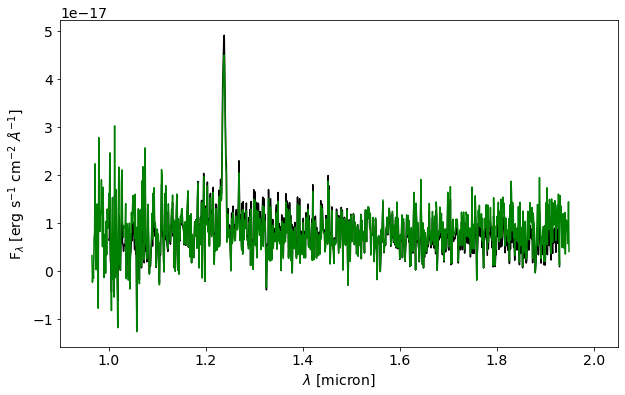

In [50]:
sens_file = HOME_PATH + '/grizli/CONF/sens_0720_2020.fits'
sens_cat2 = Table.read(sens_file)
print(sens_cat2.colnames)

from scipy import interpolate

R1 = interpolate.interp1d(sens_cat1['WAVELENGTH'],sens_cat1['SENSITIVITY'])
w10,w11 = sens_cat1['WAVELENGTH'][0],sens_cat1['WAVELENGTH'][-1]

R2 = interpolate.interp1d(sens_cat2['WAVELENGTH'],sens_cat2['SENSITIVITY'])
w20,w21 = sens_cat2['WAVELENGTH'][0],sens_cat2['WAVELENGTH'][-1]

fig = plt.figure()
p1 = fig.add_subplot(111)

for i, key in enumerate(beams.keys()):
    print(key)
    print()
    w, f, e = beams[key].beam.optimal_extract(beams[key].model+beams[key].grism.data['SCI'], bin=0)
    #w, f, e = beams[key].beam.optimal_extract(beams[key].grism.data['SCI'], 
    #                                          ivar=1./(beams[key].grism.data['ERR'])**2,bin=0)
    
    print(w)
    
    # Method 4
    
    i10 = np.argmin(np.abs(w-w10))
    i11 = np.argmin(np.abs(w-w11))
    
    i20 = np.argmin(np.abs(w-w10))
    i21 = np.argmin(np.abs(w-w11))
    
    w1 = w[i10:i11]
    f1 = f[i10:i11]
    e1 = e[i10:i11]
    
    w2 = w[i20:i21]
    f2 = f[i20:i21]
    e2 = e[i20:i21]
    
    response1 = [R1(w_el) for w_el in w1]
    
    response2 = [R2(w_el) for w_el in w2]
    
    flux1 = f1/response1
    noise1 = e1/response1
    
    flux2 = f2/response2
    noise2 = e2/response2
    
    
    # plot spectrum
    p1.plot(w1/1.e4, flux1, c="k") # linestyle='steps-mid')
    #p1.plot(w1/1.e4, noise1, c="r") # linestyle='steps-mid')
    p1.plot(w2/1.e4, flux2, c="g") # linestyle='steps-mid')
    #p1.plot(w2/1.e4, noise2, c="r") # linestyle='steps-mid')

#p.legend(fontsize=14)
p1.set_xlim(0.9, 2.05)
#p.set_ylim(0.0,0.025)
#p1.set_ylim(-2e-22,6e-22) # shows noise level
p1.set_xlabel(r'$\lambda$ [micron]')
p1.set_ylabel(r'F$_{\lambda}$ [erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$]')



  wave    flux  
------- --------
 2000.0  4.3e-19
 2002.0  4.3e-19
 2004.0  4.3e-19
 2006.0 4.31e-19
 2008.0 4.31e-19
 2010.0 4.31e-19
 2012.0 4.31e-19
 2014.0 4.32e-19
 2016.0 4.32e-19
 2018.0 4.32e-19
    ...      ...
39980.0 2.26e-19
39982.0 2.26e-19
39984.0 2.26e-19
39986.0 2.26e-19
39988.0 2.26e-19
39990.0 2.26e-19
39992.0 2.25e-19
39994.0 2.25e-19
39996.0 2.25e-19
39998.0 2.25e-19
40000.0 2.25e-19
Length = 19001 rows


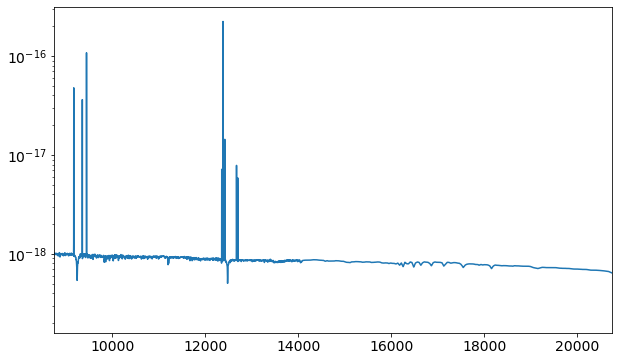

In [51]:
#/Users/gwalth/Dropbox/Research/sims/Galacticus/new_spectra
#SPEC_PATH = "/Users/gwalth/Dropbox/Research/aXeSIM/Roman/aXeSIM_Roman/SIMDATA/new_spectra"
#SPEC_PATH = "/Users/gwalth/Dropbox/Research/sims/Galacticus/bkup_2022.0120/spectra"
SPEC_PATH = "/Users/gwalth/Dropbox/Research/sims/Galacticus/sed_galacticus_ForGreg"
# ATLAS number 2118, modspec=1752
#primer_number=2118 # old
primer_number=1571 

#specdat = SPEC_PATH + "/ATLAS_1deg_subsample_spec_%06d.dat" % (primer_number)
specdat = SPEC_PATH + "/ATLAS_1deg_spec_%06d.dat" % (primer_number)
specdata = Table.read(specdat,format="ascii",names=('wave','flux'))
print(specdata)

fig = plt.figure()
p1 = fig.add_subplot(111)
p1.plot(specdata["wave"],specdata["flux"],label="Input spectra")
# [Ang] [erg/s/cm^2/Ang]
p1.set_xlim(8750,20750)
p1.set_yscale("log")
#p1.set_ylabel("e-/s per erg/s/cm$^2$/Ang") # according to axe_manual
#p1.legend()

In [52]:
beam = 'beam__%05d.grism.A.fits' % (id)
#new_beam = '{0}_{1:05d}.beams.fits'.format(root, id)
new_beam = beam.replace(".fits","_GLW.fits")

hdu = pyfits.open(beam)
print(hdu[0].header)
hdu.info()


ext = 0
hdu[ext].header['EXPTIME'] = hdu['SCI'].header['EXPTIME']
hdu.writeto(new_beam,clobber=True)
hdu.info()

SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                    8 / array data type                                NAXIS   =                    0 / number of array dimensions                     EXTEND  =                    T                                                  ID      =                 4178 / Object ID                                      PAD     =                  800 / Padding of input image                         BEAM    = 'A       '           / Grism order ("beam")                           XCENTER =  -0.4973650650019863 / Offset of centroid wrt thumb center            YCENTER =  -0.1608487018004325 / Offset of centroid wrt thumb center            TYOFFSET=                    0 / Cross dispersion offset of the trace           GPARENT = 'Roman_ATLAS_1deg_random2022_2022-01-27T06:04:27_RN0_v6_slitless_fin&'CONTINUE  'al.fits&'                                                            CONTINUE  '' / Parent grism file        

In [53]:
#mb = multifit.MultiBeam([old_beam], fcontam=0.2, group_name=root, psf=False, min_sens=0.05)
mb = multifit.MultiBeam([new_beam], fcontam=0.2, group_name=root, psf=False, min_sens=0.05)
mb.write_master_fits()

####################################################################################
# Limited set of red stellar templates
#tstar = grizli.utils.load_templates(fwhm=1200, line_complexes=True, 
#                                    fsps_templates=True, stars=True)

# Fit spectral types.  Just makes the plot now, outputs not saved 
#fig, result, tfit = mb.xfit_star(tstar=tstar, fit_background=False,
#                                 spline_correction=True, spline_args={'Rspline':5})
####################################################################################

fwhm = 650 # km/s
t0 = utils.load_templates(fwhm=fwhm, line_complexes=True, fsps_templates=True) # redshift fits, fixed line ratios
t1 = utils.load_templates(fwhm=fwhm, line_complexes=False, fsps_templates=True) # final fits

#fit = mb.xfit_redshift(templates=t0, zr=[0.65, 1.6], dz=[0.004, 0.0002], fitter='nnls')

###################################################################################
#hdu, fig = mb.drizzle_grisms_and_PAs(fcontam=0.2, flambda=False, kernel='point', 
#                                     size=32, zfit=tfit, diff=True)

beam__04178.grism.A_GLW.fits
my_roman_sims_04178.beams.fits


In [ ]:
print(fit.keys())

## Velocity resolution
[top](#Table-of-Contents)

In [54]:
# https://wfirst.ipac.caltech.edu/sims/Param_db.html#wfi_grism
# R = 461*wav # wav in microns (2pix)

c = 3e5 # km/s

# R = wav/delta_wav
# u = delta_wav/wav*c
# u = c/R

# u = (z - z0)*c/(1+z0)
# u = dz*c/(1+z0)
# dz = u(1+z0)/c
# dz = delta_wav/wav * (1+z0)


u = lambda wav: c/(461*wav)

winc = 0.25
w = np.arange(1.0,2.0+winc,winc)
for w0 in w:
    print("v = %.2f km/s (%.2f micron)" % (u(w0),w0))

print()   
for w0 in w:
    print("R = %.2f (%.2f micron)" % (461*w0,w0))

print()
z = 0.
print("z = %.2f" % (z))
for w0 in w:
    print("dz = %.6f (%.2f micron)" % (u(w0)*(1+z)/c,w0))

    
# R = wav/delta_wav
# R = 461*wav # microns
# 1/delta_wav = 461
# delta_wav = 1/461. 
print()
print("delta_wav = %.7f microns" % (1/461.))
print("delta_wav = %.3f Angstroms" % (1/461.*10000.))




v = 650.76 km/s (1.00 micron)
v = 520.61 km/s (1.25 micron)
v = 433.84 km/s (1.50 micron)
v = 371.86 km/s (1.75 micron)
v = 325.38 km/s (2.00 micron)

R = 461.00 (1.00 micron)
R = 576.25 (1.25 micron)
R = 691.50 (1.50 micron)
R = 806.75 (1.75 micron)
R = 922.00 (2.00 micron)

z = 0.00
dz = 0.002169 (1.00 micron)
dz = 0.001735 (1.25 micron)
dz = 0.001446 (1.50 micron)
dz = 0.001240 (1.75 micron)
dz = 0.001085 (2.00 micron)

delta_wav = 0.0021692 microns
delta_wav = 21.692 Angstroms


In [ ]:
# Generic resolution test

R = 1000.

c = 3e5 # km/s

# R = wav/delta_wav
# u = delta_wav/wav*c
# u = c/R

# u = (z - z0)*c/(1+z0)
# u = dz*c/(1+z0)
# dz = u(1+z0)/c

u = lambda wav: c/R

winc = 0.25
w = np.arange(0.3,2.0+winc,winc)
for w0 in w:
    print("v = %.2f km/s (%.2f micron)" % (u(w0),w0))

print()   
for w0 in w:
    print("R = %.2f (%.2f micron)" % (461*w0,w0))

print()
z = 0.
print("z = %.2f" % (z))
for w0 in w:
    print("dz = %.6f (%.2f micron)" % (u(w0)*(1+z)/c,w0))

    
# R = wav/delta_wav
# delta_wav = wav/R

print()
for w0 in w:
    print("delta_wav = %.7f microns" % (w0/R))
    print("delta_wav = %.3f Angstroms" % (w0/R*10000.))



In [77]:
# dz = delta_wav/wav * (1+z0)

dz = 100/12400.* (1+0.88615)
print(dz)

0.015210887096774194


## Fit redshift to source
[top](#Table-of-Contents)

load_master_fits: my_roman_sims_04178.beams.fits
1 Roman_ATLAS_1deg_random2022_2022-01-27T06:04:27_RN0_v6_slitless_final.fits GRISM
User templates! N=16 

  0.0500    6556.7 (0.0500) 1/335
  0.0542    6555.7 (0.0542) 2/335
  0.0584    6554.6 (0.0584) 3/335
  0.0627    6554.4 (0.0627) 4/335
  0.0669    6553.3 (0.0669) 5/335
  0.0712    6552.3 (0.0712) 6/335
  0.0755    6552.3 (0.0755) 7/335
  0.0798    6552.1 (0.0798) 8/335
  0.0841    6552.8 (0.0798) 9/335
  0.0885    6551.5 (0.0885) 10/335
  0.0929    6550.2 (0.0929) 11/335
  0.0972    6550.0 (0.0972) 12/335
  0.1016    6549.4 (0.1016) 13/335
  0.1060    6548.3 (0.1060) 14/335
  0.1105    6548.5 (0.1060) 15/335
  0.1149    6548.1 (0.1149) 16/335
  0.1194    6547.6 (0.1194) 17/335
  0.1239    6541.0 (0.1239) 18/335
  0.1284    6531.7 (0.1284) 19/335
  0.1329    6509.2 (0.1329) 20/335
  0.1375    6544.9 (0.1329) 21/335
  0.1420    6541.6 (0.1329) 22/335
  0.1466    6542.1 (0.1329) 23/335
  0.1512    6544.6 (0.1329) 24/335
  0.1558    65

  1.5929    6541.1 (1.4714) 227/335
  1.6033    6544.1 (1.4714) 228/335
  1.6138    6542.9 (1.4714) 229/335
  1.6242    6539.0 (1.4714) 230/335
  1.6348    6538.3 (1.4714) 231/335
  1.6453    6537.6 (1.4714) 232/335
  1.6559    6539.5 (1.4714) 233/335
  1.6666    6540.9 (1.4714) 234/335
  1.6773    6538.1 (1.4714) 235/335
  1.6880    6536.4 (1.4714) 236/335
  1.6988    6542.0 (1.4714) 237/335
  1.7096    6538.5 (1.4714) 238/335
  1.7204    6535.7 (1.4714) 239/335
  1.7313    6536.3 (1.4714) 240/335
  1.7423    6533.9 (1.4714) 241/335
  1.7533    6536.9 (1.4714) 242/335
  1.7643    6537.7 (1.4714) 243/335
  1.7754    6535.7 (1.4714) 244/335
  1.7865    6530.9 (1.4714) 245/335
  1.7977    6537.8 (1.4714) 246/335
  1.8089    6539.3 (1.4714) 247/335
  1.8202    6540.0 (1.4714) 248/335
  1.8315    6536.0 (1.4714) 249/335
  1.8428    6544.1 (1.4714) 250/335
  1.8542    6550.2 (1.4714) 251/335
  1.8656    6537.3 (1.4714) 252/335
  1.8771    6530.3 (1.4714) 253/335
  1.8887    6531.2 (1.4714) 

- 1.4697    6200.5 (1.4697) 2/21
- 1.4699    6193.2 (1.4699) 3/21
- 1.4701    6186.6 (1.4701) 4/21
- 1.4703    6180.7 (1.4703) 5/21
- 1.4705    6175.6 (1.4705) 6/21
- 1.4707    6171.3 (1.4707) 7/21
- 1.4709    6167.8 (1.4709) 8/21
- 1.4711    6165.2 (1.4711) 9/21
- 1.4713    6163.5 (1.4713) 10/21
- 1.4715    6162.7 (1.4715) 11/21
- 1.4717    6162.8 (1.4715) 12/21
- 1.4719    6163.9 (1.4715) 13/21
- 1.4721    6165.9 (1.4715) 14/21
- 1.4723    6168.8 (1.4715) 15/21
- 1.4725    6172.7 (1.4715) 16/21
- 1.4727    6177.4 (1.4715) 17/21
- 1.4729    6183.0 (1.4715) 18/21
- 1.4731    6189.4 (1.4715) 19/21
- 1.4733    6196.6 (1.4715) 20/21
- 1.4735    6204.5 (1.4715) 21/21
Drizzle line -> OII-7325 (2.19 1.20)
Drizzle line -> ArIII-7138 (1.09 1.08)
Drizzle line -> SII  (-0.24 1.15)
Drizzle line -> Ha   (-1.51 1.04)
Drizzle line -> OI-6302 (-1.94 1.25)
Drizzle line -> HeI-5877 (0.48 0.98)
Drizzle line -> OIII (30.23 1.48)
Drizzle line -> Hb   (3.45 1.45)
Drizzle line -> OIII-4363 (-0.60 1.81)
Driz

(<grizli.multifit.MultiBeam at 0x7fcd57039a90>,
 None,
 <GTable length=416>
        zgrid                chi2       ...   pdf          risk       
       float64             float64      ... float64      float64      
 -------------------- ----------------- ... ------- ------------------
 0.050000000000000044 6556.692129715997 ...   1e-40 0.9363185484802337
  0.05420841121120912 6555.678383772028 ...   1e-40 0.9359640772915041
  0.05843368977948726 6554.635532528668 ...   1e-40 0.9356052682130109
  0.06267590330938178 6554.353511284958 ...   1e-40 0.9352420489361635
  0.06693511967639965 6553.299002829477 ...   1e-40 0.9348743456244016
  0.07121140702809359  6552.28022406557 ...   1e-40 0.9345020828743159
  0.07550483378515271 6552.266222061531 ...   1e-40 0.9341251836756167
  0.07981546864249633 6552.100411891201 ...   1e-40 0.9337435693699134
   0.0841433805703744 6552.778265778669 ...   1e-40 0.9333571596082654
  0.08848863881546998 6551.476982085667 ...   1e-40 0.9329658723074583
 

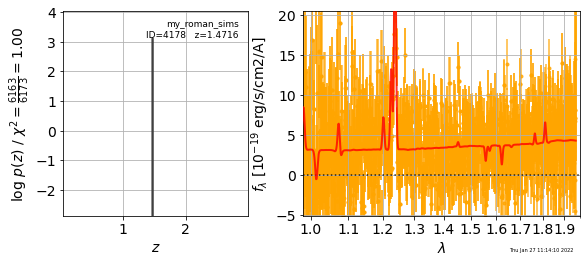

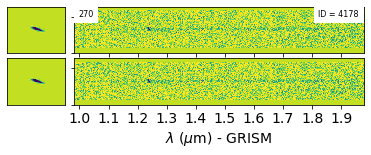

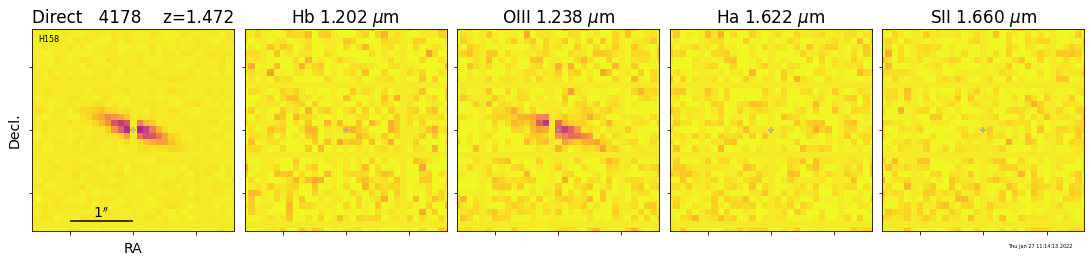

In [55]:
fitting.run_all(id, t0, t1, fit_only_beams=True, fwhm=fwhm, zr=[0.05, 3.0], 
                dz=[0.004, 0.0002], fitter=['nnls', 'bounded'], group_name=root)

## Display Redshift Fit
[top](#Table-of-Contents)


H158
Filename: my_roman_sims_04178.1D.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      19   ()      
  1  GRISM         1 BinTableHDU     38   947R x 8C   [D, D, D, K, D, D, D, D]   
None
['wave', 'flux', 'err', 'npix', 'flat', 'contam', 'line', 'cont']
1 2


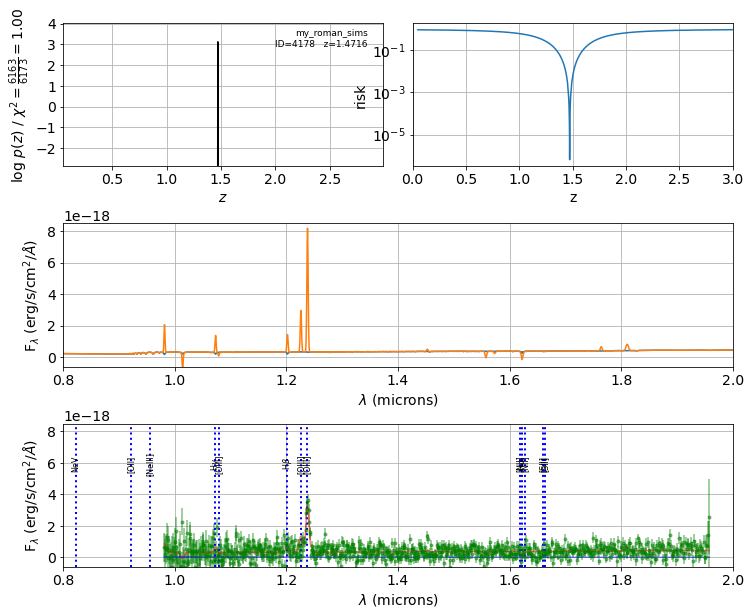

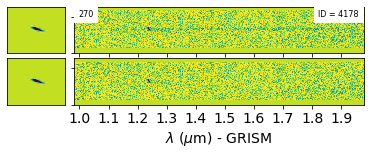

In [56]:
display_grizli(root, id, w0=0.8, w1=2.0, labels=1)

## Compare to primer

In [57]:
#print(primer)
print(primer.keys())
modspec_number = 8127
#print(primer_number)
#print(primer[modspec_number-1])

filt = primer["NUMBER"] == primer_number # ATLAS NUMBER
print(primer[filt])

filt = primer["SPECTEMP"] == modspec_number # MODSPEC NUMBER
print(primer[filt])

['NUMBER', 'RA', 'DEC', 'X_IMAGE', 'Y_IMAGE', 'A_IMAGE', 'B_IMAGE', 'THETA_IMAGE', 'MAG_F1600W', 'REDSHIFT', 'SPECTEMP', 'MODIMAGE']
NUMBER       RA           DEC      X_IMAGE ... REDSHIFT SPECTEMP MODIMAGE
------ ------------- ------------- ------- ... -------- -------- --------
  1571 10.0265397928 -0.0393050944 1087.55 ... 0.886151     8127        0
NUMBER       RA           DEC      X_IMAGE ... REDSHIFT SPECTEMP MODIMAGE
------ ------------- ------------- ------- ... -------- -------- --------
  1571 10.0265397928 -0.0393050944 1087.55 ... 0.886151     8127        0


## Parallel Tests
[top](#Table-of-Contents)

In [ ]:
import multiprocessing as mp
import time

import numpy as np
#from time import time

def howmany_within_range(row, minimum, maximum):
    """Returns how many numbers lie within `maximum` and `minimum` in a given `row`"""
    count = 0
    for n in row:
        if minimum <= n <= maximum:
            count = count + 1
    return count

# Prepare data
np.random.RandomState(100)
arr = np.random.randint(0, 10, size=[200000, 5])
data = arr.tolist()
data[:5]

In [ ]:
mp.cpu_count()

In [ ]:
t0 = time.time()
results = [howmany_within_range(row, 4, 8) for row in data]
t1 = time.time()
print(t1-t0,"seconds")
print(results[:10])

In [ ]:
t0 = time.time()
# Step 1: Init multiprocessing.Pool()
pool = mp.Pool(mp.cpu_count())

# Step 2: `pool.apply` the `howmany_within_range()`
results = [pool.apply(howmany_within_range, args=(row, 4, 8)) for row in data]

# Step 3: Don't forget to close
pool.close()    

t1 = time.time()
print(t1-t0,"seconds")
print(results[:10])

## Parallel Redshift Fitting Tests
[top](#Table-of-Contents)

In [ ]:

#def fit_redshift_parallel(id, grismflt, temp0, temp1, fwhm, root):
def fit_redshift_parallel(id, fwhm, root):
    print(id)
    
    #beams = OrderedDict()

    is_cgs, spectrum_1d, b = Roman.object_dispersers[id]
    cutout = grizli.model.BeamCutout(Roman, b['A'], min_sens=0,) # min_mask=0) 

    cutout.beam.compute_model()  
    cutout.contam = cutout.beam.cutout_from_full_image(Roman.model)
    if id in Roman.object_dispersers:
        cutout.contam -= cutout.beam.model

    #beams[Roman.grism.instrument] = cutout

    cutout.write_fits() # still learning

    beam = 'beam__%05d.grism.A.fits' % (id)
    new_beam = beam.replace(".fits","_GLW.fits")

    ext = 0
    hdu = pyfits.open(beam)
    hdu[ext].header['EXPTIME'] = hdu['SCI'].header['EXPTIME']
    hdu.writeto(new_beam,clobber=True)

    mb = multifit.MultiBeam([new_beam], fcontam=0.2, group_name=root, psf=False, min_sens=0.05)
    mb.write_master_fits()

    fitting.run_all(id, temp0, temp1, fit_only_beams=True, fwhm=fwhm, zr=[0.05, 3.0], 
                    dz=[0.004, 0.0002], fitter=['nnls', 'bounded'], group_name=root)
    
    return 1

def collect_result(result):
    global results
    results.append(result)
        
    
fwhm = 325 # km/s
temp0 = utils.load_templates(fwhm=fwhm, line_complexes=True, fsps_templates=True) # redshift fits, fixed line ratios
temp1 = utils.load_templates(fwhm=fwhm, line_complexes=False, fsps_templates=True) # final fits

#for id in phot['NUMBER'][:3]:

# This breaks if there is a magnitude cut!!!
#Narr = phot['NUMBER']

#t0 = time.time()
Narr = phot['NUMBER'][:5]
#[fit_redshift_parallel(id, Roman, temp0, temp1, fwhm, root) for id in Narr]
#t1 = time.time()
#print(t1-t0,"seconds")


## version 1 
#t0 = time.time()
## Step 1: Init multiprocessing.Pool()
#pool = mp.Pool(mp.cpu_count())

## Step 2: `pool.apply` the `fit_redshift_parallel()`
##[pool.apply(fit_redshift_parallel, args=(id, Roman, temp0, temp1, fwhm, root)) for id in Narr]

#[pool.apply(fit_redshift_parallel, args=(id, fwhm, root)) for id in Narr]

## Step 3: Don't forget to close
#pool.close()
#t1 = time.time()
#print(t1-t0,"seconds")


# version 2 
t0 = time.time()
# Step 1: Init multiprocessing.Pool()
pool = mp.Pool(mp.cpu_count())

results = []
# Step 3: Use loop to parallelize
for id in Narr:
    pool.apply_async(fit_redshift_parallel, args=(id, fwhm, root), callback=collect_result)

# Step 4: Close Pool and let all the processes complete    
pool.close()
pool.join()  # postpones the execution of next line of code until all processes in the queue are done.

t1 = time.time()
print(t1-t0,"seconds")


In [ ]:
def fit_redshift_parallel(id, fwhm, root):
    print(id)
    
    #beams = OrderedDict()

    is_cgs, spectrum_1d, b = Roman.object_dispersers[id]
    cutout = grizli.model.BeamCutout(Roman, b['A'], min_sens=0,) # min_mask=0) 

    cutout.beam.compute_model()  
    cutout.contam = cutout.beam.cutout_from_full_image(Roman.model)
    if id in Roman.object_dispersers:
        cutout.contam -= cutout.beam.model

    #beams[Roman.grism.instrument] = cutout

    cutout.write_fits() # still learning

    beam = 'beam__%05d.grism.A.fits' % (id)
    new_beam = beam.replace(".fits","_GLW.fits")

    ext = 0
    hdu = pyfits.open(beam)
    hdu[ext].header['EXPTIME'] = hdu['SCI'].header['EXPTIME']
    hdu.writeto(new_beam,clobber=True)

    mb = multifit.MultiBeam([new_beam], fcontam=0.2, group_name=root, psf=False, min_sens=0.05)
    mb.write_master_fits()

    fitting.run_all(id, temp0, temp1, fit_only_beams=True, fwhm=fwhm, zr=[0.05, 3.0], 
                    dz=[0.004, 0.0002], fitter=['nnls', 'bounded'], group_name=root)
    
    return 1

def collect_result(result):
    global results
    results.append(result)
        

In [ ]:
fwhm = 325 # km/s
temp0 = utils.load_templates(fwhm=fwhm, line_complexes=True, fsps_templates=True) # redshift fits, fixed line ratios
temp1 = utils.load_templates(fwhm=fwhm, line_complexes=False, fsps_templates=True) # final fits

In [ ]:
t0 = time.time()
# This breaks if there is a magnitude cut!!!
Narr = phot['NUMBER'][:40]
[fit_redshift_parallel(id, fwhm, root) for id in Narr]
t1 = time.time()
print(t1-t0,"seconds")


In [ ]:
Narr = phot['NUMBER'][:40]

# version 1 
t0 = time.time()
# Step 1: Init multiprocessing.Pool()
pool = mp.Pool(mp.cpu_count())

# Step 2: `pool.apply` the `fit_redshift_parallel()`
#[pool.apply(fit_redshift_parallel, args=(id, Roman, temp0, temp1, fwhm, root)) for id in Narr]

[pool.apply(fit_redshift_parallel, args=(id, fwhm, root)) for id in Narr]

# Step 3: Don't forget to close
pool.close()
t1 = time.time()
print(t1-t0,"seconds")



In [ ]:
print(results)

In [ ]:
Narr = phot['NUMBER'][:40]

# version 2 
t0 = time.time()
# Step 1: Init multiprocessing.Pool()
pool = mp.Pool(mp.cpu_count())

results = []
# Step 3: Use loop to parallelize
for id in Narr:
    pool.apply_async(fit_redshift_parallel, args=(id, fwhm, root), callback=collect_result)

# Step 4: Close Pool and let all the processes complete    
pool.close()
pool.join()  # postpones the execution of next line of code until all processes in the queue are done.

t1 = time.time()
print(t1-t0,"seconds")


## Coordinates check
[top](#Table-of-Contents)

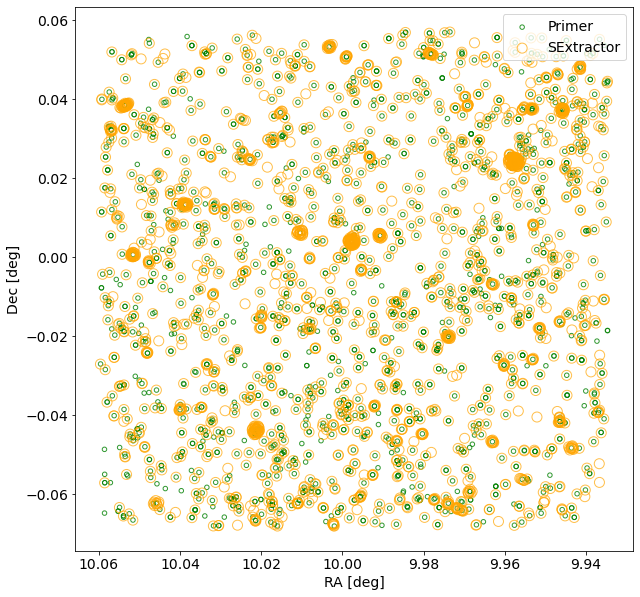

In [30]:
fig = plt.figure(figsize=[10,10])

mag_limit = 25

filt_pri = primer['MAG_F1600W'] < mag_limit
filt_sex = phot['MAG_AUTO'] < mag_limit

ax = fig.add_subplot(111)
ax.scatter(primer['RA'][filt_pri], primer['DEC'][filt_pri], s=20,
               edgecolor='green', facecolor='none', alpha=0.8, label="Primer")
ax.scatter(phot['X_WORLD'][filt_sex], phot['Y_WORLD'][filt_sex], s=100,
               edgecolor='orange', facecolor='none', alpha=0.7, label="SExtractor")

ax.set_xlabel("RA [deg]")
ax.set_ylabel("Dec [deg]")
ax.invert_xaxis()

ax.legend(loc=1)

<span style="color:red">
Different sims may have different WCS centers!
</span>
Use this test as a way to check the correct center was used.


aXeSIM conf | hdf5
:----------:|:---:
Roman.G150.wcs_v1.RN0.conf | galacticus_ATLAS_1deg2_subsample.hdf5  
Roman.G150.wcs_v2.RN0.conf | galacticus_ForGreg.hdf5

## SED check

[top](#Table-of-Contents)

/Users/gwalth/Dropbox/Research/sims/Galacticus/sed_galacticus_ForGreg/ATLAS_1deg_spec_001571.dat
  wave    flux  
------- --------
 2000.0  4.3e-19
 2002.0  4.3e-19
 2004.0  4.3e-19
 2006.0 4.31e-19
 2008.0 4.31e-19
 2010.0 4.31e-19
 2012.0 4.31e-19
 2014.0 4.32e-19
 2016.0 4.32e-19
 2018.0 4.32e-19
    ...      ...
39980.0 2.26e-19
39982.0 2.26e-19
39984.0 2.26e-19
39986.0 2.26e-19
39988.0 2.26e-19
39990.0 2.26e-19
39992.0 2.25e-19
39994.0 2.25e-19
39996.0 2.25e-19
39998.0 2.25e-19
40000.0 2.25e-19
Length = 19001 rows


Text(0.5, 0, 'Wavelength [Ang]')

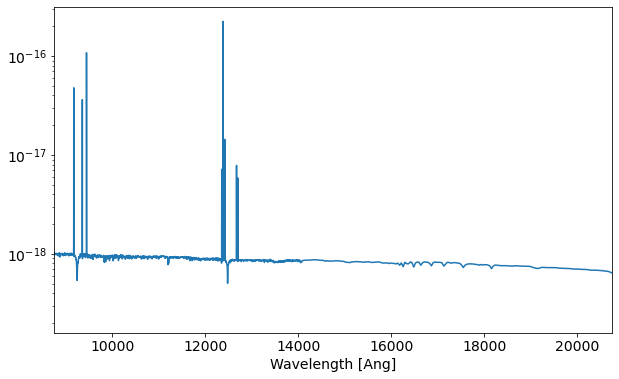

In [58]:
#/Users/gwalth/Dropbox/Research/sims/Galacticus/new_spectra
#SPEC_PATH = "/Users/gwalth/Dropbox/Research/aXeSIM/Roman/aXeSIM_Roman/SIMDATA/new_spectra"
#SPEC_PATH = "/Users/gwalth/Dropbox/Research/sims/Galacticus/bkup_2022.0120/spectra"
SPEC_PATH = "/Users/gwalth/Dropbox/Research/sims/Galacticus/sed_galacticus_ForGreg"
# ATLAS number 2118, modspec=1752
#number = 2118 # old
number = 1571

#specdat = SPEC_PATH + "/ATLAS_1deg_subsample_spec_%06d.dat" % (number)
specdat = SPEC_PATH + "/ATLAS_1deg_spec_%06d.dat" % (number)
print(specdat)
specdata = Table.read(specdat,format="ascii",names=('wave','flux'))
print(specdata)

fig = plt.figure()
p1 = fig.add_subplot(111)
p1.plot(specdata["wave"],specdata["flux"],label="Input spectra")
# [Ang] [erg/s/cm^2/Ang]
p1.set_xlim(8750,20750)
p1.set_yscale("log")

p1.set_xlabel("Wavelength [Ang]")
#p1.set_ylabel("e-/s per erg/s/cm$^2$/Ang") # according to axe_manual
#p1.legend()

In [59]:
SPEC_PATH = "/Users/gwalth/Dropbox/Research/sims/Galacticus/sed_galacticus_ForGreg"
AXE_PATH = "/Users/gwalth/data/Roman/grizli/my_roman_sims/Prep/"

axe_image = "Roman_ATLAS_1deg_random2022_2022-01-27T06:04:27_RN0_v6_images.fits"
axe_spec = "Roman_ATLAS_1deg_random2022_2022-01-27T06:04:27_RN0_v6_spectra.fits"

In [60]:
f = AXE_PATH + axe_spec
pf = pyfits.open(f)
N = len(pf)

#number = 2118 # old
number = 1571

for i in np.arange(N)+1:
    
    head = pf[i].header
    
    specname = head['SPECNAME']
    extname = head['EXTNAME']
    mag_ab = head['MAG_AB']
    
    number_found = int(specname.split("_")[-1])
    if number == number_found:
        print(i,number_found)
    
    # SPECNAME= 'ATLAS_1deg_spec_029260' / Name of spectrum 

    #tab = pf[ext].data
    #flux = tab["flux"]
    #wav = tab["wav_nm"]

8127 1571


IndexError: list index out of range

9657
/Users/gwalth/Dropbox/Research/sims/Galacticus/sed_galacticus_ForGreg/ATLAS_1deg_spec_001571.dat
  wave    flux  
------- --------
 2000.0  4.3e-19
 2002.0  4.3e-19
 2004.0  4.3e-19
 2006.0 4.31e-19
 2008.0 4.31e-19
 2010.0 4.31e-19
 2012.0 4.31e-19
 2014.0 4.32e-19
 2016.0 4.32e-19
 2018.0 4.32e-19
    ...      ...
39980.0 2.26e-19
39982.0 2.26e-19
39984.0 2.26e-19
39986.0 2.26e-19
39988.0 2.26e-19
39990.0 2.26e-19
39992.0 2.25e-19
39994.0 2.25e-19
39996.0 2.25e-19
39998.0 2.25e-19
40000.0 2.25e-19
Length = 19001 rows
['WAVELENGTH', 'SENSITIVITY', 'ERROR']


XTENSION= 'TABLE   '           / ASCII table extension                          
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   30 / length of dimension 1                          
NAXIS2  =                19001 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    2 / number of table fields                         
TTYPE1  = 'WAV_NM  '                                                            
TFORM1  = 'E15.7   '                                                            
TBCOL1  =                    1                                                  
TTYPE2  = 'FLUX    '                                                            
TFORM2  = 'E15.7   '        

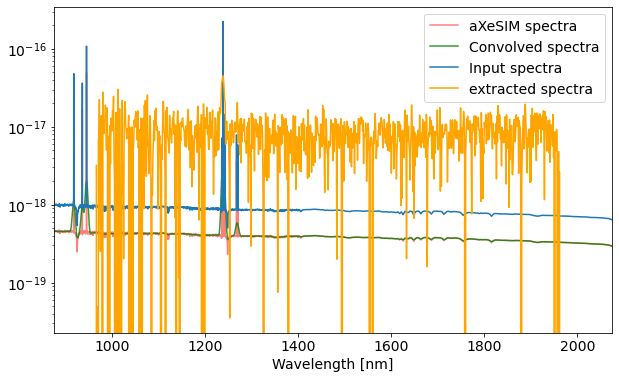

In [66]:
f = AXE_PATH + axe_spec
#f = axe_spec
#ext = 4468 # old
ext = 8127
pf = pyfits.open(f)
print(len(pf))

#print(key)

tab = pf[ext].data

flux = tab["flux"]
wav = tab["wav_nm"]


delta_wav = 1/461. # microns
delta_wav *= 1000. # nm

delt = 2.0*(delta_wav)/(wav[1]-wav[0])


stddev = delt/2*sqrt(2*log(2))
psf_func = models.Gaussian1D(amplitude=1.0, stddev=stddev)
x = np.arange(4*int(delt)+1)-2*int(delt)
psf = psf_func(x)
psf /= psf.sum() # normalize

new_flux = np.convolve(flux, psf,mode='same')


fig = plt.figure()
p1 = fig.add_subplot(111)
p1.plot(wav,flux,label="aXeSIM spectra",c="r",alpha=0.5)
p1.plot(wav,new_flux,label="Convolved spectra",c="g",alpha=0.8)
# [nm] [erg/s/cm^2/Ang]

#######################
#######################
#######################

# ATLAS number 2118, modspec=1752
#number = 2118 # old
number = 1571 # new

#specdat = SPEC_PATH + "/ATLAS_1deg_subsample_spec_%06d.dat" % (number)
specdat = SPEC_PATH + "/ATLAS_1deg_spec_%06d.dat" % (number)
print(specdat)
specdata = Table.read(specdat,format="ascii",names=('wave','flux'))
print(specdata)

p1.plot(specdata["wave"]/10.,specdata["flux"],label="Input spectra")
# [Ang] [erg/s/cm^2/Ang]

######################
sens_file = HOME_PATH + '/grizli/CONF/sens_0720_2020.fits'
sens_cat2 = Table.read(sens_file)
print(sens_cat2.colnames)

from scipy import interpolate

R = interpolate.interp1d(sens_cat2['WAVELENGTH'],sens_cat2['SENSITIVITY'])
w0,w1 = sens_cat2['WAVELENGTH'][0],sens_cat2['WAVELENGTH'][-1]

w, f, e = beams[key].beam.optimal_extract(beams[key].model+beams[key].grism.data['SCI'], bin=0)
#w, f, e = beams[key].beam.optimal_extract(beams[key].grism.data['SCI'], 
#                                          ivar=1./(beams[key].grism.data['ERR'])**2,bin=0)
    
#print(w)
    
# Method 4

i0 = np.argmin(np.abs(w-w0))
i1 = np.argmin(np.abs(w-w1))

w = w[i0:i1]
f = f[i0:i1]
e = e[i0:i1]
    
response = [R(w_el) for w_el in w]
    
flux2 = f/response
noise2 = e/response
    
# plot spectrum
p1.plot(w/10., flux2, c="orange", label="extracted spectra") # linestyle='steps-mid')
# factor of 10 off, could be WAV_AB being wrong (i.e. 1600 instead of 160)

p1.set_xlim(875.0,2075.0)
#p1.set_ylim(1e-15,1e-21)
p1.set_yscale("log")
p1.set_xlabel("Wavelength [nm]")
#p1.set_ylabel("e-/s per erg/s/cm$^2$/Ang") # according to axe_manual

p1.legend(loc=1)



pf[ext].header

In [74]:
f = AXE_PATH + axe_image

ext = 3
pf = pyfits.open(f)
print(len(pf))
pf[ext].header

#tab = pf[ext].data

#fig = plt.figure()
#p1 = fig.add_subplot(111)
#p1.plot(tab["wav_nm"],tab["flux"],label="Input spectra")
## [Ang] [erg/s/cm^2/Ang]
#p1.set_xlim(875.0,2075.0)
#p1.set_yscale("log")
##p1.set_ylabel("e-/s per erg/s/cm$^2$/Ang") # according to axe_manual
##p1.legend()

6


XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   88                                                  
NAXIS2  =                   88                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        
DATE    = '2007-10-22T15:39:17' / Date FITS file was generated                  
IRAF-TLM= '18:39:17 (22/10/2007)' / Time of last modification                   
CREATED = 'Mon Oct 22 17:09:08 2007'  / Time and date file was created          
INSTRUME= 'NEWNICMOS_2'        / Simulated instrument                           
FOCUS   =               0.00